# Experiment 1

## sklearnDigits

Average Generation: 50000.0


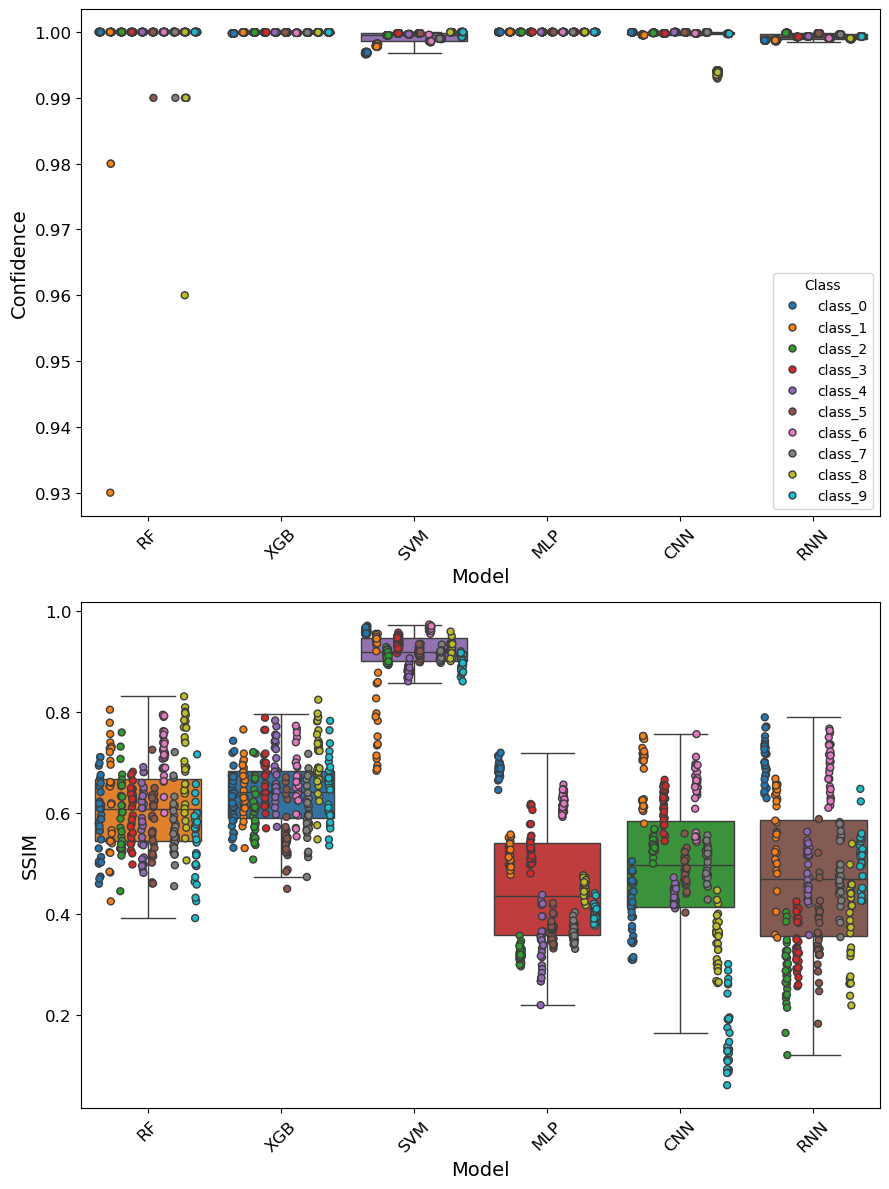

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_sklearnDigits_aggregated.csv")


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Keep only relevant columns
data = data[["Model", "Class", "Generation"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Plot the boxplots and stripplots
plt.figure(figsize=(9, 12))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(2, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


Kruskal-Wallis p-value for Confidence (Target Class): 9.65e-285
Kruskal-Wallis p-value for SSIM (Target Class): 1.05e-223


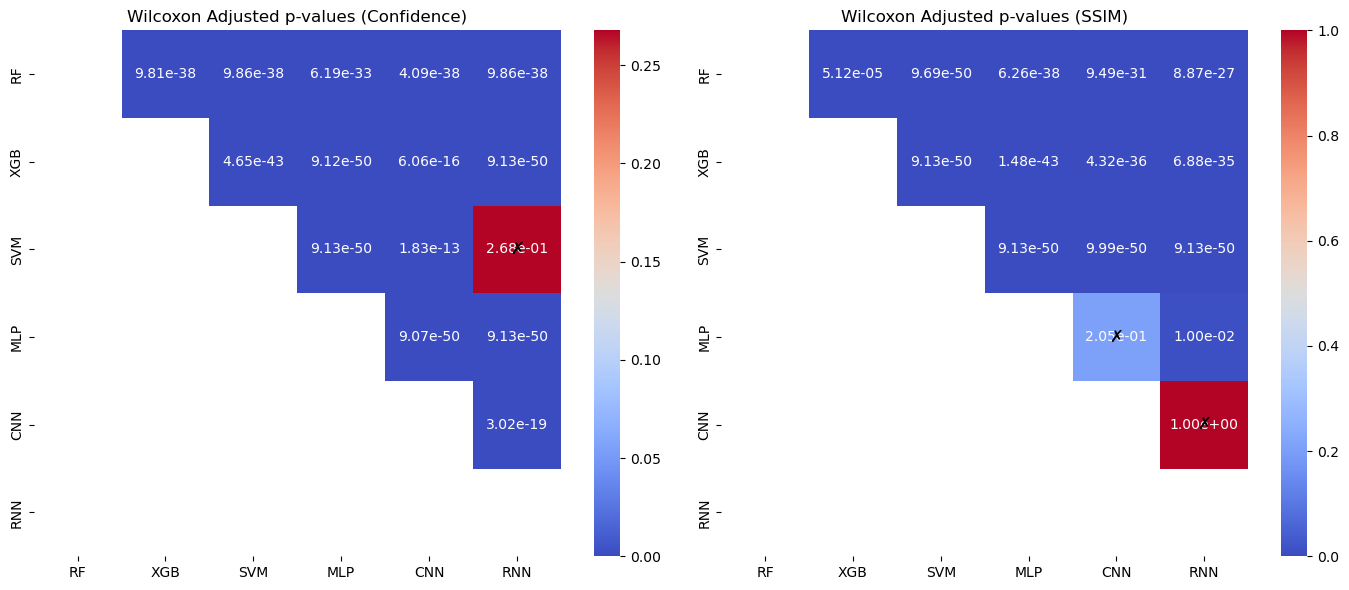

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data_path = "/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_sklearnDigits_aggregated.csv"
data = pd.read_csv(data_path)


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionaries to store results for Kruskal-Wallis and Wilcoxon
heatmap_data_kruskal = {}
heatmap_data_wilcoxon = {}

# Perform Kruskal-Wallis test first, then Wilcoxon tests
for metric in target_metrics:
    # Kruskal-Wallis test across all models
    grouped_data = [data[data["Model"] == model][metric].dropna() for model in model_order]
    
    # Perform Kruskal-Wallis test
    stat, p_kruskal = kruskal(*grouped_data, nan_policy='omit')
    
    # Store Kruskal-Wallis results in a dictionary
    heatmap_data_kruskal[metric] = p_kruskal

    # Wilcoxon pairwise comparisons
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust Wilcoxon p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix for heatmap visualization
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix

# Display Kruskal-Wallis test results
for metric, p_value in heatmap_data_kruskal.items():
    print(f"Kruskal-Wallis p-value for {metric}: {p_value:.2e}")

# Plot the Wilcoxon heatmaps with significance markers (✗ for p ≥ 0.05)
fig, axes = plt.subplots(1, len(target_metrics), figsize=(14, 6))

for i, (metric, alias) in enumerate(zip(target_metrics, metric_aliases)):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    
    # Add ✗ marks for non-significant p-values (p ≥ 0.05)
    for x in range(len(model_order)):
        for y in range(x + 1, len(model_order)):  # Only upper triangle
            if not np.isnan(heatmap_data_wilcoxon[metric][x, y]) and heatmap_data_wilcoxon[metric][x, y] >= 0.05:
                ax.text(y + 0.5, x + 0.5, "✗", ha="center", va="center", fontsize=12, color="black", fontweight="bold")

    ax.set_title(f"Wilcoxon Adjusted p-values ({alias})")

plt.tight_layout()
plt.show()


## mnistDigits

Average Generation: 100000.0


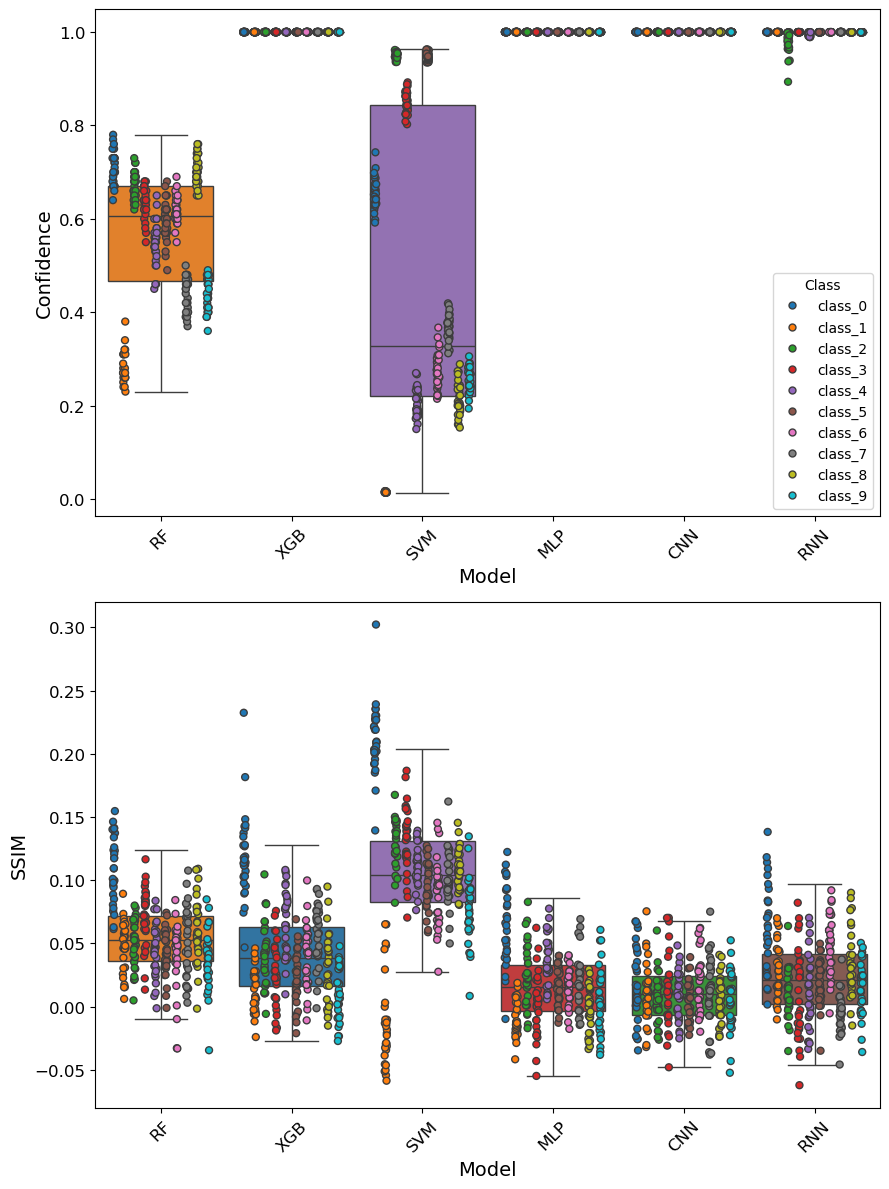

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_mnistDigits_aggregated.csv")

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Keep only relevant columns
data = data[["Model", "Class", "Generation"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Plot the boxplots and stripplots
plt.figure(figsize=(9, 12))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(2, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


Kruskal-Wallis p-value for Confidence (Target Class): 0.00e+00
Kruskal-Wallis p-value for SSIM (Target Class): 1.95e-147


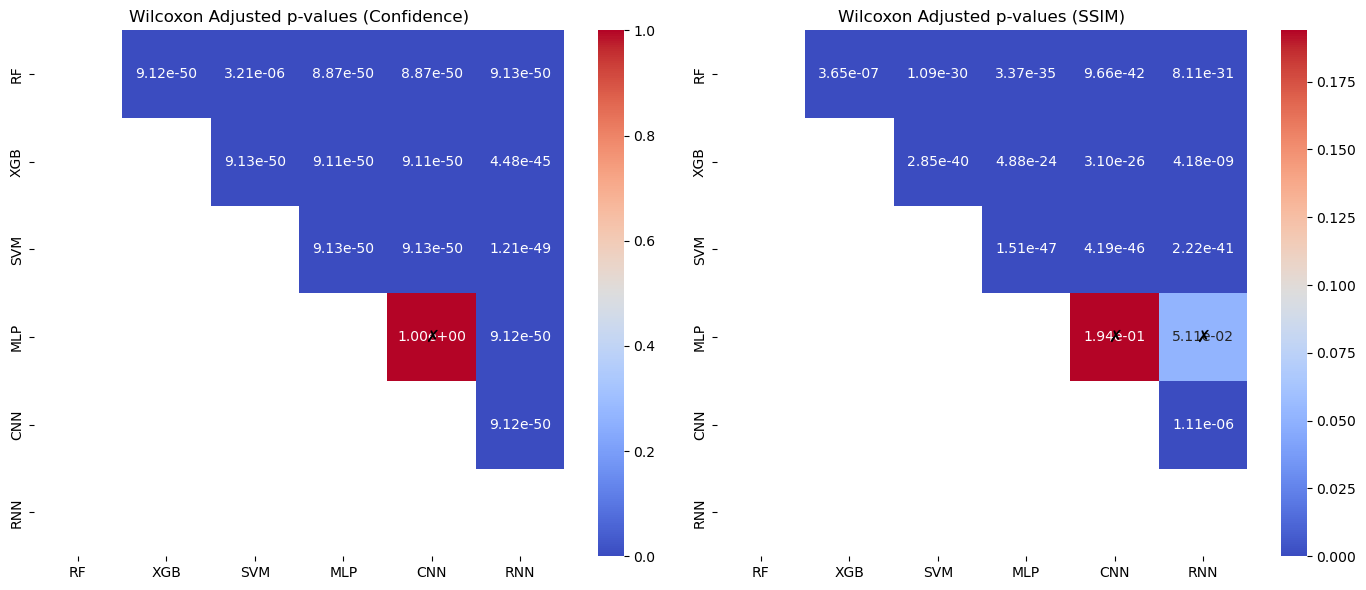

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data_path = "/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_mnistDigits_aggregated.csv"
data = pd.read_csv(data_path)


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionaries to store results for Kruskal-Wallis and Wilcoxon
heatmap_data_kruskal = {}
heatmap_data_wilcoxon = {}

# Perform Kruskal-Wallis test first, then Wilcoxon tests
for metric in target_metrics:
    # Kruskal-Wallis test across all models
    grouped_data = [data[data["Model"] == model][metric].dropna() for model in model_order]
    
    # Perform Kruskal-Wallis test
    stat, p_kruskal = kruskal(*grouped_data, nan_policy='omit')
    
    # Store Kruskal-Wallis results in a dictionary
    heatmap_data_kruskal[metric] = p_kruskal

    # Wilcoxon pairwise comparisons
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust Wilcoxon p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix for heatmap visualization
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix

# Display Kruskal-Wallis test results
for metric, p_value in heatmap_data_kruskal.items():
    print(f"Kruskal-Wallis p-value for {metric}: {p_value:.2e}")

# Plot the Wilcoxon heatmaps with significance markers (✗ for p ≥ 0.05)
fig, axes = plt.subplots(1, len(target_metrics), figsize=(14, 6))

for i, (metric, alias) in enumerate(zip(target_metrics, metric_aliases)):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    
    # Add ✗ marks for non-significant p-values (p ≥ 0.05)
    for x in range(len(model_order)):
        for y in range(x + 1, len(model_order)):  # Only upper triangle
            if not np.isnan(heatmap_data_wilcoxon[metric][x, y]) and heatmap_data_wilcoxon[metric][x, y] >= 0.05:
                ax.text(y + 0.5, x + 0.5, "✗", ha="center", va="center", fontsize=12, color="black", fontweight="bold")

    ax.set_title(f"Wilcoxon Adjusted p-values ({alias})")

plt.tight_layout()
plt.show()


## mnistFashion

Average Generation: 100000.0


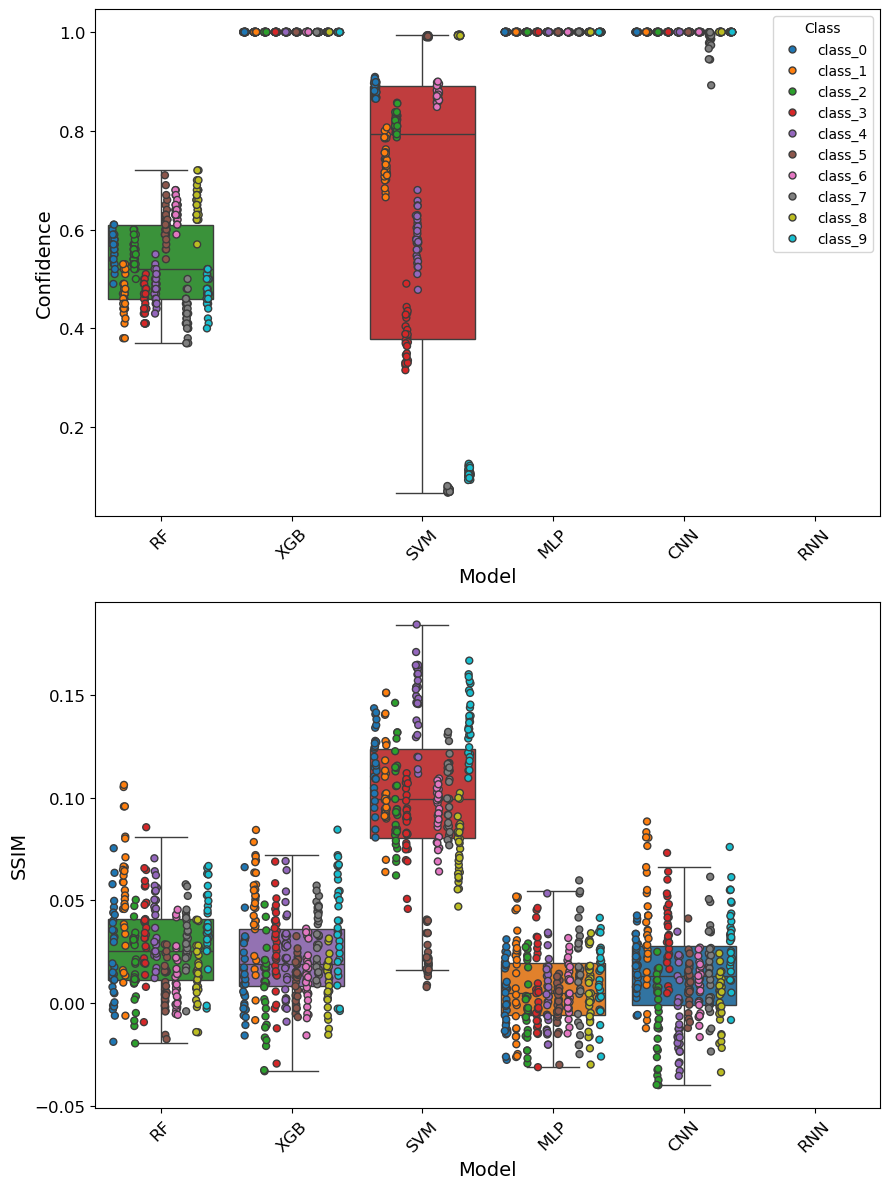

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_mnistFashion_aggregated.csv")

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Keep only relevant columns
data = data[["Model", "Class", "Generation"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Plot the boxplots and stripplots
plt.figure(figsize=(9, 12))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(2, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


Kruskal-Wallis p-value for Confidence (Target Class): 1.85e-284
Kruskal-Wallis p-value for SSIM (Target Class): 1.94e-147


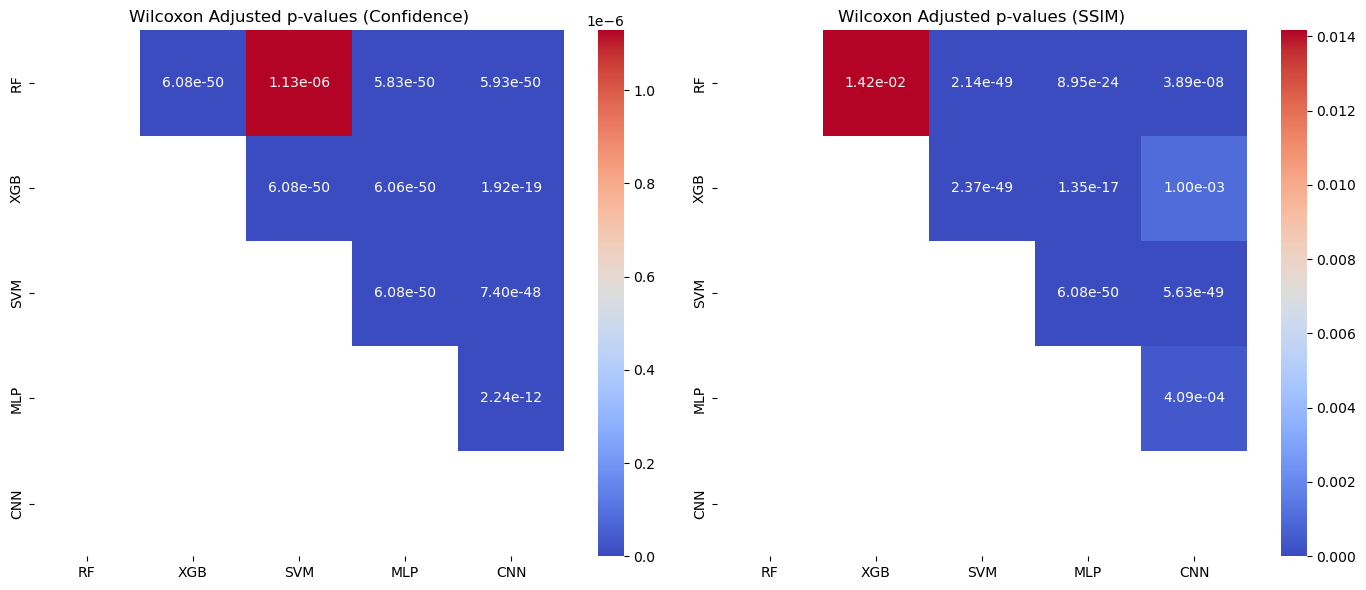

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data_path = "/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_mnistFashion_aggregated.csv"
data = pd.read_csv(data_path)


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionaries to store results for Kruskal-Wallis and Wilcoxon
heatmap_data_kruskal = {}
heatmap_data_wilcoxon = {}

# Perform Kruskal-Wallis test first, then Wilcoxon tests
for metric in target_metrics:
    # Kruskal-Wallis test across all models
    grouped_data = [data[data["Model"] == model][metric].dropna() for model in model_order]
    
    # Perform Kruskal-Wallis test
    stat, p_kruskal = kruskal(*grouped_data, nan_policy='omit')
    
    # Store Kruskal-Wallis results in a dictionary
    heatmap_data_kruskal[metric] = p_kruskal

    # Wilcoxon pairwise comparisons
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust Wilcoxon p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix for heatmap visualization
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix

# Display Kruskal-Wallis test results
for metric, p_value in heatmap_data_kruskal.items():
    print(f"Kruskal-Wallis p-value for {metric}: {p_value:.2e}")

# Plot the Wilcoxon heatmaps with significance markers (✗ for p ≥ 0.05)
fig, axes = plt.subplots(1, len(target_metrics), figsize=(14, 6))

for i, (metric, alias) in enumerate(zip(target_metrics, metric_aliases)):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    
    # Add ✗ marks for non-significant p-values (p ≥ 0.05)
    for x in range(len(model_order)):
        for y in range(x + 1, len(model_order)):  # Only upper triangle
            if not np.isnan(heatmap_data_wilcoxon[metric][x, y]) and heatmap_data_wilcoxon[metric][x, y] >= 0.05:
                ax.text(y + 0.5, x + 0.5, "✗", ha="center", va="center", fontsize=12, color="black", fontweight="bold")

    ax.set_title(f"Wilcoxon Adjusted p-values ({alias})")

plt.tight_layout()
plt.show()


# Experiment 2_2

## sklearnDigits

Average Generation: 50000.0


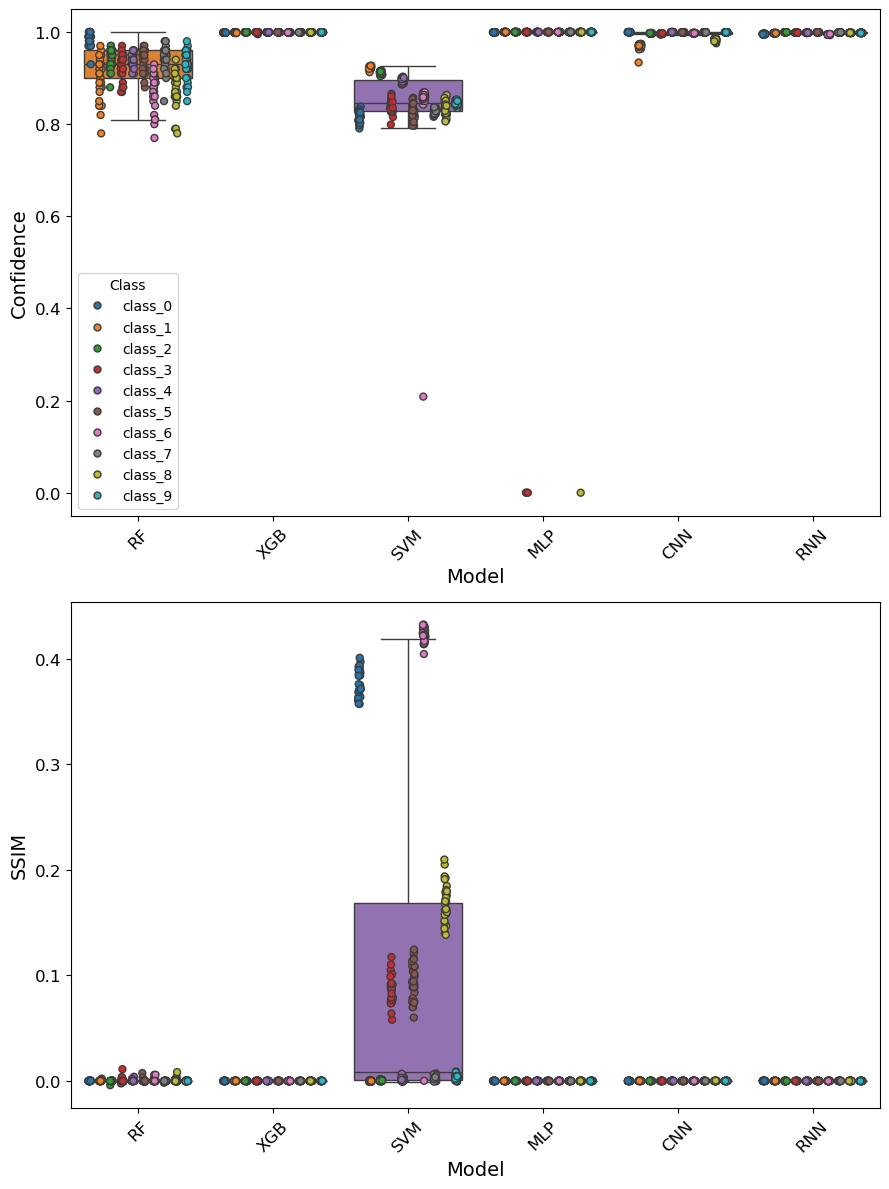

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_sklearnDigits_aggregated.csv")


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Keep only relevant columns
data = data[["Model", "Class", "Generation"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Plot the boxplots and stripplots
plt.figure(figsize=(9, 12))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(2, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


Kruskal-Wallis p-value for Confidence (Target Class): 6.48e-310
Kruskal-Wallis p-value for SSIM (Target Class): 1.91e-96


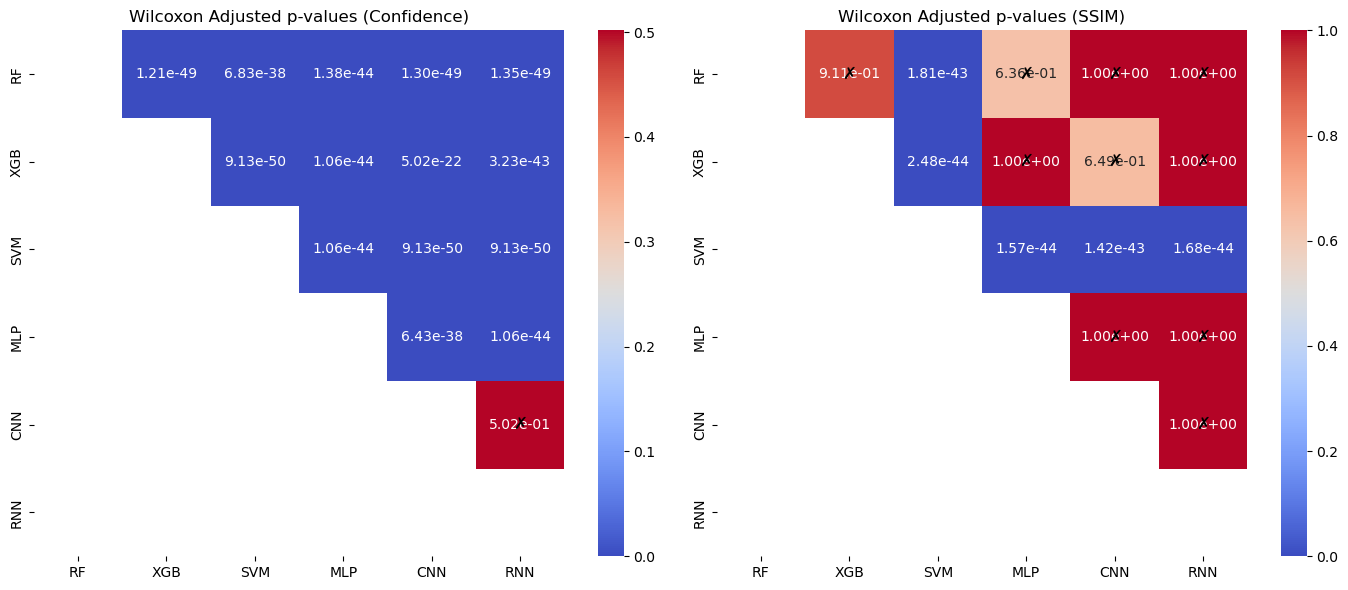

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data_path = "/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_sklearnDigits_aggregated.csv"
data = pd.read_csv(data_path)


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionaries to store results for Kruskal-Wallis and Wilcoxon
heatmap_data_kruskal = {}
heatmap_data_wilcoxon = {}

# Perform Kruskal-Wallis test first, then Wilcoxon tests
for metric in target_metrics:
    # Kruskal-Wallis test across all models
    grouped_data = [data[data["Model"] == model][metric].dropna() for model in model_order]
    
    # Perform Kruskal-Wallis test
    stat, p_kruskal = kruskal(*grouped_data, nan_policy='omit')
    
    # Store Kruskal-Wallis results in a dictionary
    heatmap_data_kruskal[metric] = p_kruskal

    # Wilcoxon pairwise comparisons
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust Wilcoxon p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix for heatmap visualization
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix

# Display Kruskal-Wallis test results
for metric, p_value in heatmap_data_kruskal.items():
    print(f"Kruskal-Wallis p-value for {metric}: {p_value:.2e}")

# Plot the Wilcoxon heatmaps with significance markers (✗ for p ≥ 0.05)
fig, axes = plt.subplots(1, len(target_metrics), figsize=(14, 6))

for i, (metric, alias) in enumerate(zip(target_metrics, metric_aliases)):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    
    # Add ✗ marks for non-significant p-values (p ≥ 0.05)
    for x in range(len(model_order)):
        for y in range(x + 1, len(model_order)):  # Only upper triangle
            if not np.isnan(heatmap_data_wilcoxon[metric][x, y]) and heatmap_data_wilcoxon[metric][x, y] >= 0.05:
                ax.text(y + 0.5, x + 0.5, "✗", ha="center", va="center", fontsize=12, color="black", fontweight="bold")

    ax.set_title(f"Wilcoxon Adjusted p-values ({alias})")

plt.tight_layout()
plt.show()


## mnistDigits

Average Generation: 100000.0


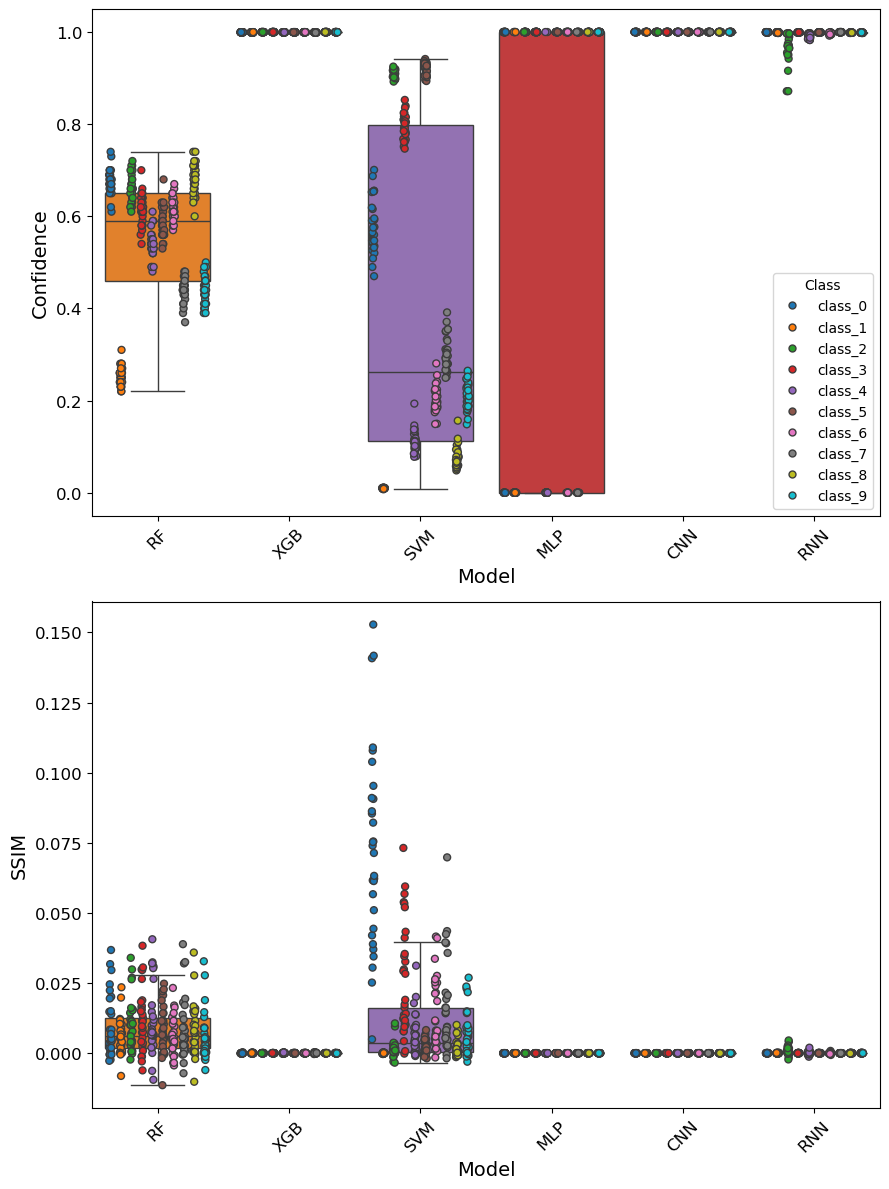

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_mnistDigits_aggregated.csv")

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Keep only relevant columns
data = data[["Model", "Class", "Generation"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Plot the boxplots and stripplots
plt.figure(figsize=(9, 12))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(2, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


Kruskal-Wallis p-value for Confidence (Target Class): 9.34e-244
Kruskal-Wallis p-value for SSIM (Target Class): 4.93e-126


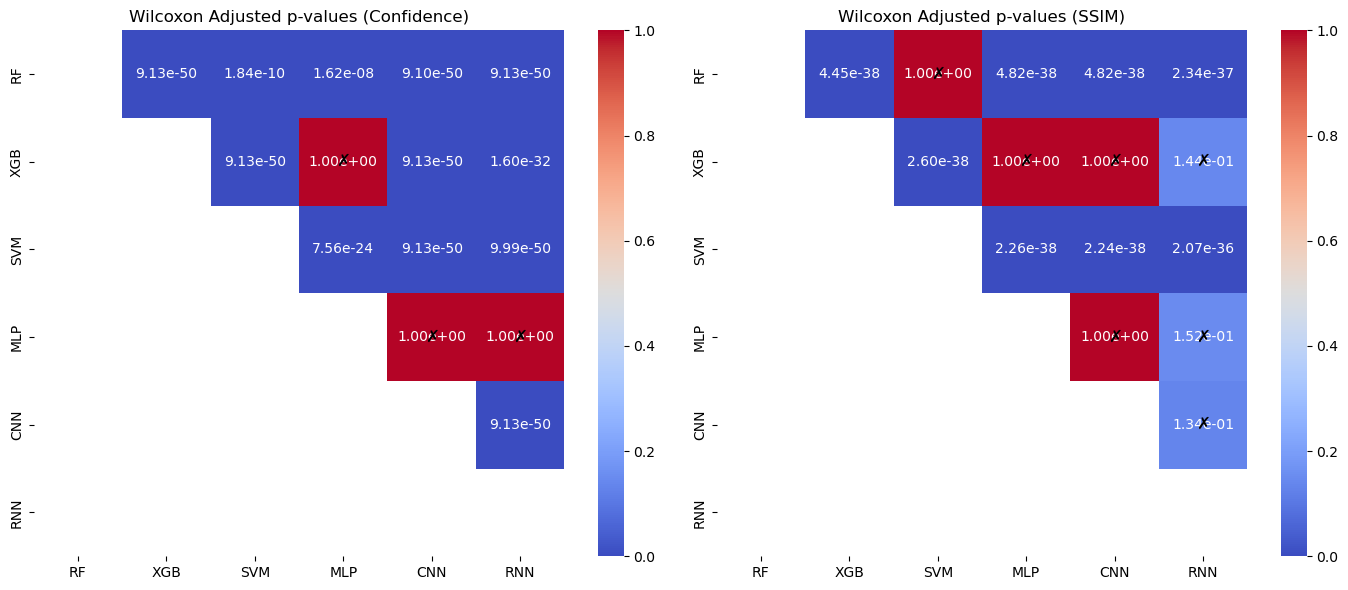

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data_path = "/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_mnistDigits_aggregated.csv"
data = pd.read_csv(data_path)


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionaries to store results for Kruskal-Wallis and Wilcoxon
heatmap_data_kruskal = {}
heatmap_data_wilcoxon = {}

# Perform Kruskal-Wallis test first, then Wilcoxon tests
for metric in target_metrics:
    # Kruskal-Wallis test across all models
    grouped_data = [data[data["Model"] == model][metric].dropna() for model in model_order]
    
    # Perform Kruskal-Wallis test
    stat, p_kruskal = kruskal(*grouped_data, nan_policy='omit')
    
    # Store Kruskal-Wallis results in a dictionary
    heatmap_data_kruskal[metric] = p_kruskal

    # Wilcoxon pairwise comparisons
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust Wilcoxon p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix for heatmap visualization
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix

# Display Kruskal-Wallis test results
for metric, p_value in heatmap_data_kruskal.items():
    print(f"Kruskal-Wallis p-value for {metric}: {p_value:.2e}")

# Plot the Wilcoxon heatmaps with significance markers (✗ for p ≥ 0.05)
fig, axes = plt.subplots(1, len(target_metrics), figsize=(14, 6))

for i, (metric, alias) in enumerate(zip(target_metrics, metric_aliases)):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    
    # Add ✗ marks for non-significant p-values (p ≥ 0.05)
    for x in range(len(model_order)):
        for y in range(x + 1, len(model_order)):  # Only upper triangle
            if not np.isnan(heatmap_data_wilcoxon[metric][x, y]) and heatmap_data_wilcoxon[metric][x, y] >= 0.05:
                ax.text(y + 0.5, x + 0.5, "✗", ha="center", va="center", fontsize=12, color="black", fontweight="bold")

    ax.set_title(f"Wilcoxon Adjusted p-values ({alias})")

plt.tight_layout()
plt.show()


## mnistFashion

Average Generation: 100000.0


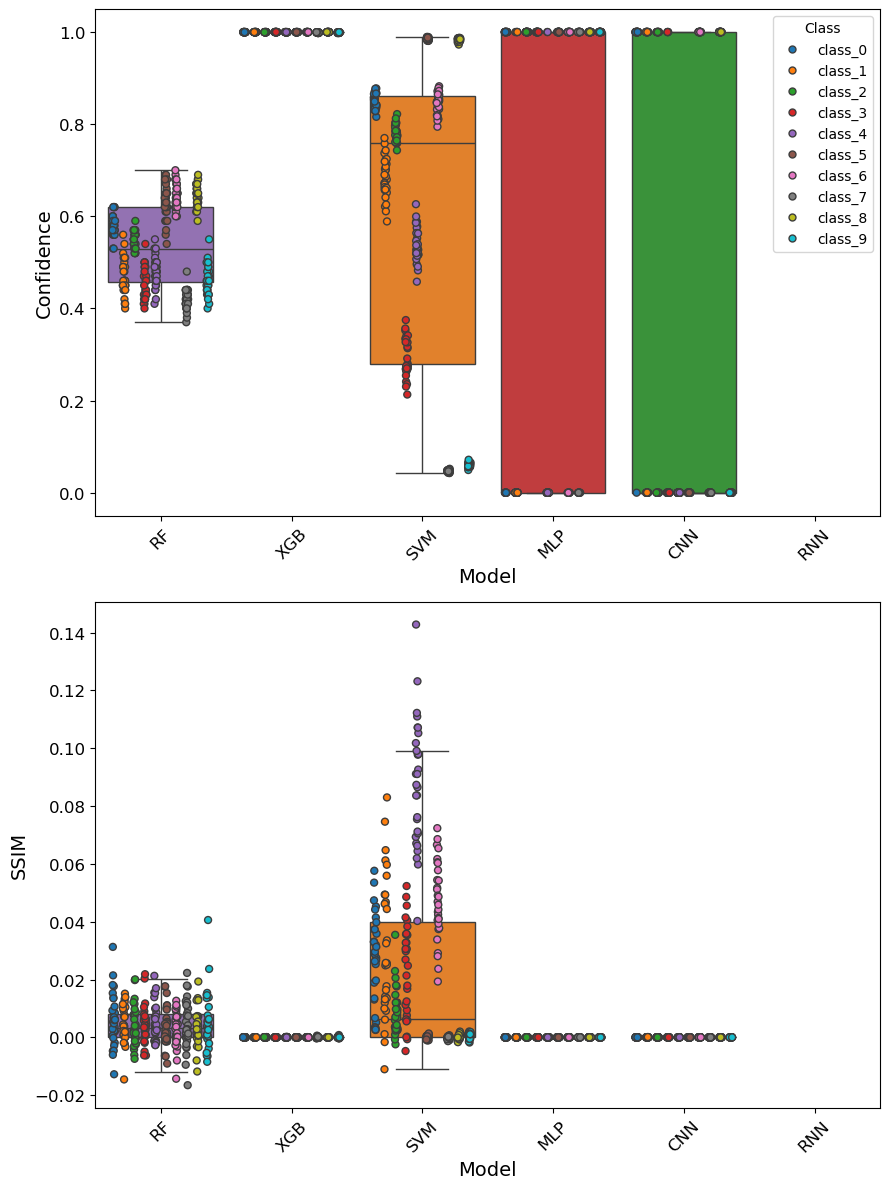

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_mnistFashion_aggregated.csv")

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Keep only relevant columns
data = data[["Model", "Class", "Generation"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Plot the boxplots and stripplots
plt.figure(figsize=(9, 12))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(2, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


Kruskal-Wallis p-value for Confidence (Target Class): 1.17e-79
Kruskal-Wallis p-value for SSIM (Target Class): 5.23e-75


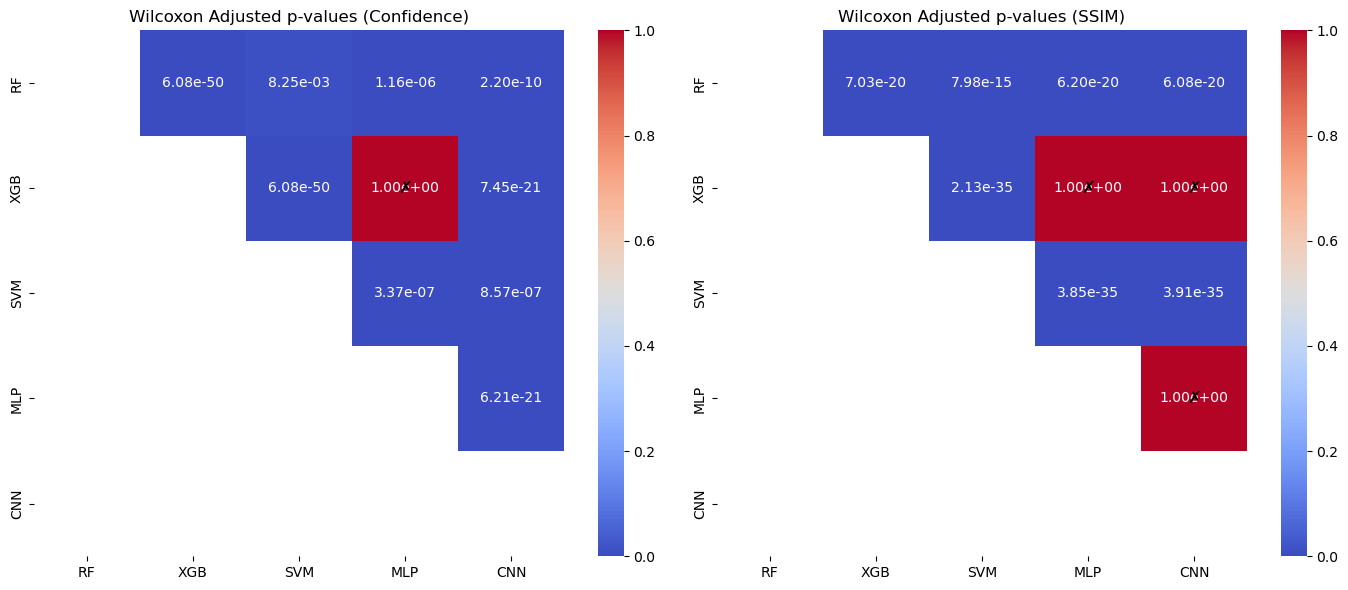

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data_path = "/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_mnistFashion_aggregated.csv"
data = pd.read_csv(data_path)


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionaries to store results for Kruskal-Wallis and Wilcoxon
heatmap_data_kruskal = {}
heatmap_data_wilcoxon = {}

# Perform Kruskal-Wallis test first, then Wilcoxon tests
for metric in target_metrics:
    # Kruskal-Wallis test across all models
    grouped_data = [data[data["Model"] == model][metric].dropna() for model in model_order]
    
    # Perform Kruskal-Wallis test
    stat, p_kruskal = kruskal(*grouped_data, nan_policy='omit')
    
    # Store Kruskal-Wallis results in a dictionary
    heatmap_data_kruskal[metric] = p_kruskal

    # Wilcoxon pairwise comparisons
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust Wilcoxon p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix for heatmap visualization
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix

# Display Kruskal-Wallis test results
for metric, p_value in heatmap_data_kruskal.items():
    print(f"Kruskal-Wallis p-value for {metric}: {p_value:.2e}")

# Plot the Wilcoxon heatmaps with significance markers (✗ for p ≥ 0.05)
fig, axes = plt.subplots(1, len(target_metrics), figsize=(14, 6))

for i, (metric, alias) in enumerate(zip(target_metrics, metric_aliases)):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    
    # Add ✗ marks for non-significant p-values (p ≥ 0.05)
    for x in range(len(model_order)):
        for y in range(x + 1, len(model_order)):  # Only upper triangle
            if not np.isnan(heatmap_data_wilcoxon[metric][x, y]) and heatmap_data_wilcoxon[metric][x, y] >= 0.05:
                ax.text(y + 0.5, x + 0.5, "✗", ha="center", va="center", fontsize=12, color="black", fontweight="bold")

    ax.set_title(f"Wilcoxon Adjusted p-values ({alias})")

plt.tight_layout()
plt.show()


# Experiment 2_1a

## sklearnDigits

Average Generation: 50000.0


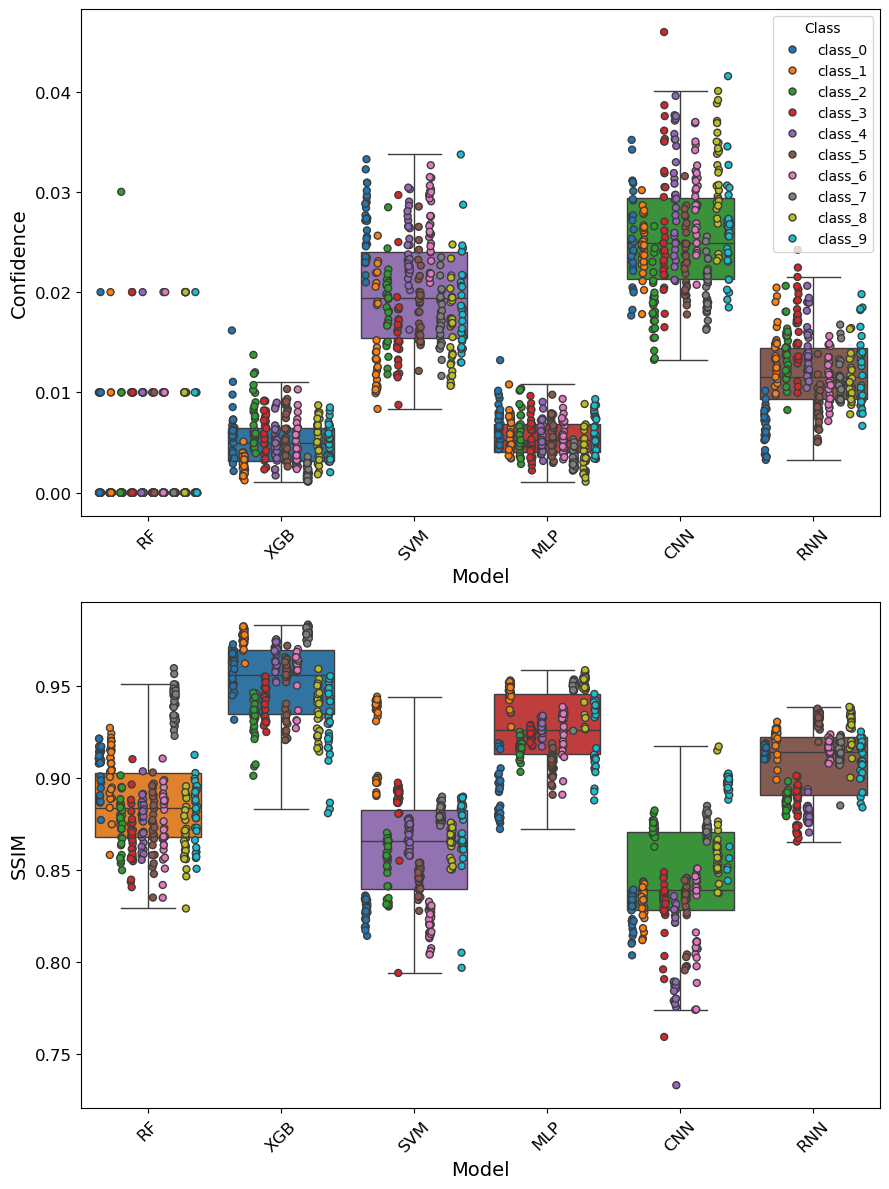

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_sklearnDigits_aggregated.csv")


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Keep only relevant columns
data = data[["Model", "Class", "Generation"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Plot the boxplots and stripplots
plt.figure(figsize=(9, 12))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(2, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


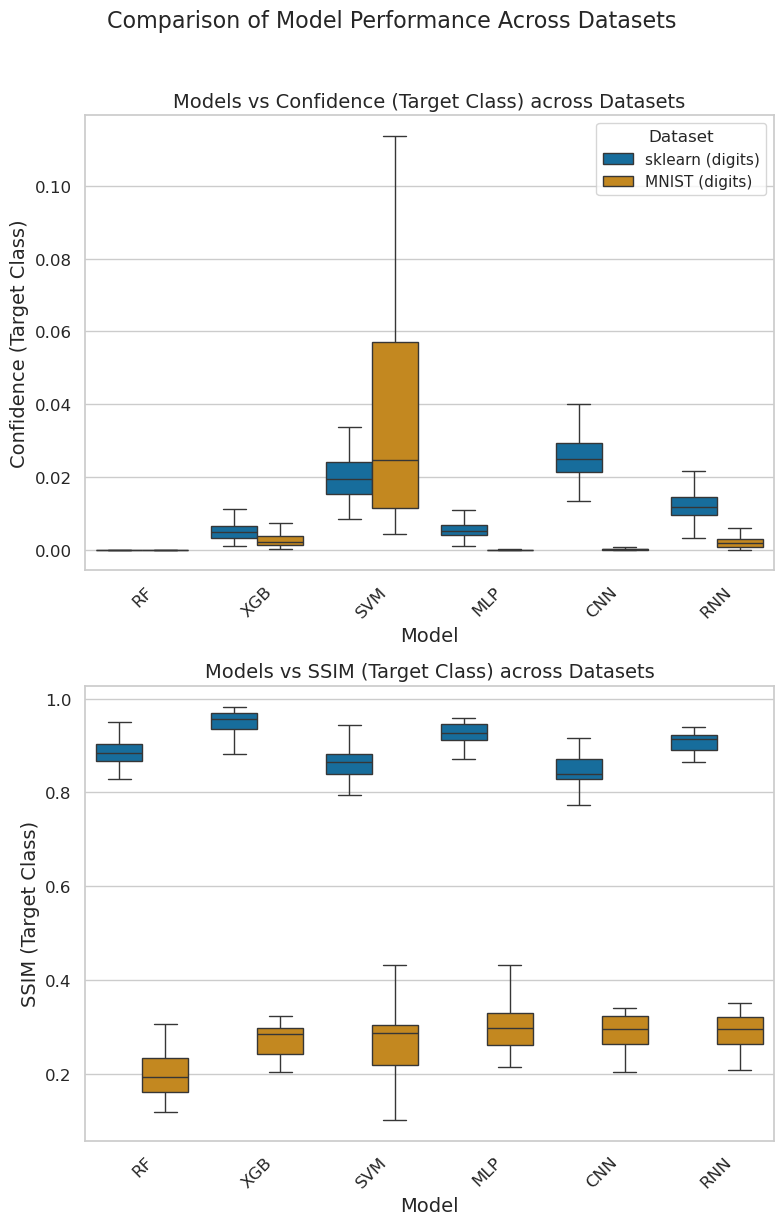

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data1 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_sklearnDigits_aggregated.csv")
data2 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_mnistDigits_aggregated.csv")

# Assign dataset labels
data1["Dataset"] = "sklearn (digits)"
data2["Dataset"] = "MNIST (digits)"

# Combine datasets
data = pd.concat([data1, data2])

# Define relevant columns
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]
dataset_order = ["sklearn (digits)", "MNIST (digits)", "MNIST (fashion)"]

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

### **Comparison Across Datasets with Correct Strip Plot Alignment** ###
plt.figure(figsize=(8, 12))

for i, metric in enumerate(target_metrics, 1):
    plt.subplot(2, 1, i)
    
    # Boxplot with dodge=True for separation
    sns.boxplot(x="Model", y=metric, hue="Dataset", data=data, 
                palette="colorblind", showfliers=False, order=model_order, dodge=True)

    # # Stripplot with dodge=True to ensure proper alignment
    # sns.stripplot(x="Model", y=metric, hue="Dataset", data=data, 
    #               palette="Set2", jitter=True, dodge=True, linewidth=0.8, edgecolor='gray', alpha=0.7, 
    #               order=model_order)

    plt.title(f"Models vs {metric} across Datasets", fontsize=14)
    plt.xlabel("Model", fontsize=14)
    plt.ylabel(metric, fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    if i == 1:
        plt.legend(title="Dataset")  # Keep dataset legend
    else:
        plt.legend().remove()

plt.suptitle("Comparison of Model Performance Across Datasets", fontsize=16, y=1.02, ha='center')
plt.tight_layout()
plt.show()


Kruskal-Wallis p-value for Confidence (Target Class): 1.18e-302
Kruskal-Wallis p-value for SSIM (Target Class): 5.80e-265


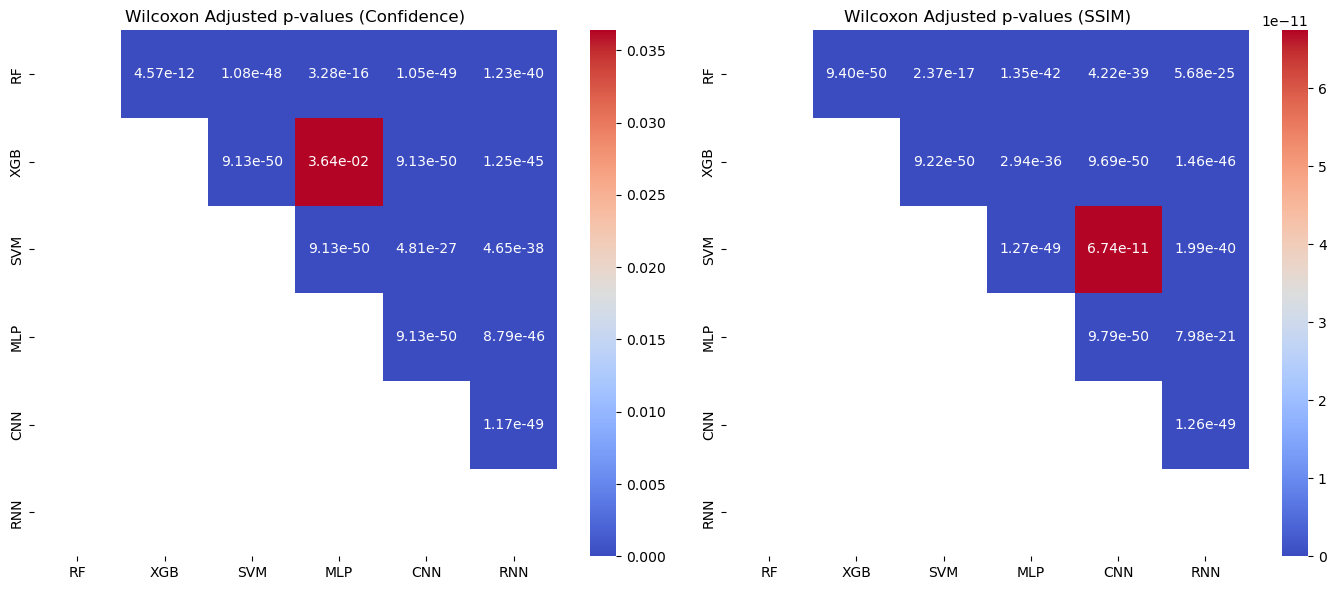

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data_path = "/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_sklearnDigits_aggregated.csv"
data = pd.read_csv(data_path)


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionaries to store results for Kruskal-Wallis and Wilcoxon
heatmap_data_kruskal = {}
heatmap_data_wilcoxon = {}

# Perform Kruskal-Wallis test first, then Wilcoxon tests
for metric in target_metrics:
    # Kruskal-Wallis test across all models
    grouped_data = [data[data["Model"] == model][metric].dropna() for model in model_order]
    
    # Perform Kruskal-Wallis test
    stat, p_kruskal = kruskal(*grouped_data, nan_policy='omit')
    
    # Store Kruskal-Wallis results in a dictionary
    heatmap_data_kruskal[metric] = p_kruskal

    # Wilcoxon pairwise comparisons
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust Wilcoxon p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix for heatmap visualization
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix

# Display Kruskal-Wallis test results
for metric, p_value in heatmap_data_kruskal.items():
    print(f"Kruskal-Wallis p-value for {metric}: {p_value:.2e}")

# Plot the Wilcoxon heatmaps with significance markers (✗ for p ≥ 0.05)
fig, axes = plt.subplots(1, len(target_metrics), figsize=(14, 6))

for i, (metric, alias) in enumerate(zip(target_metrics, metric_aliases)):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    
    # Add ✗ marks for non-significant p-values (p ≥ 0.05)
    for x in range(len(model_order)):
        for y in range(x + 1, len(model_order)):  # Only upper triangle
            if not np.isnan(heatmap_data_wilcoxon[metric][x, y]) and heatmap_data_wilcoxon[metric][x, y] >= 0.05:
                ax.text(y + 0.5, x + 0.5, "✗", ha="center", va="center", fontsize=12, color="black", fontweight="bold")

    ax.set_title(f"Wilcoxon Adjusted p-values ({alias})")

plt.tight_layout()
plt.show()


## mnistDigits

Average Generation: 100000.0


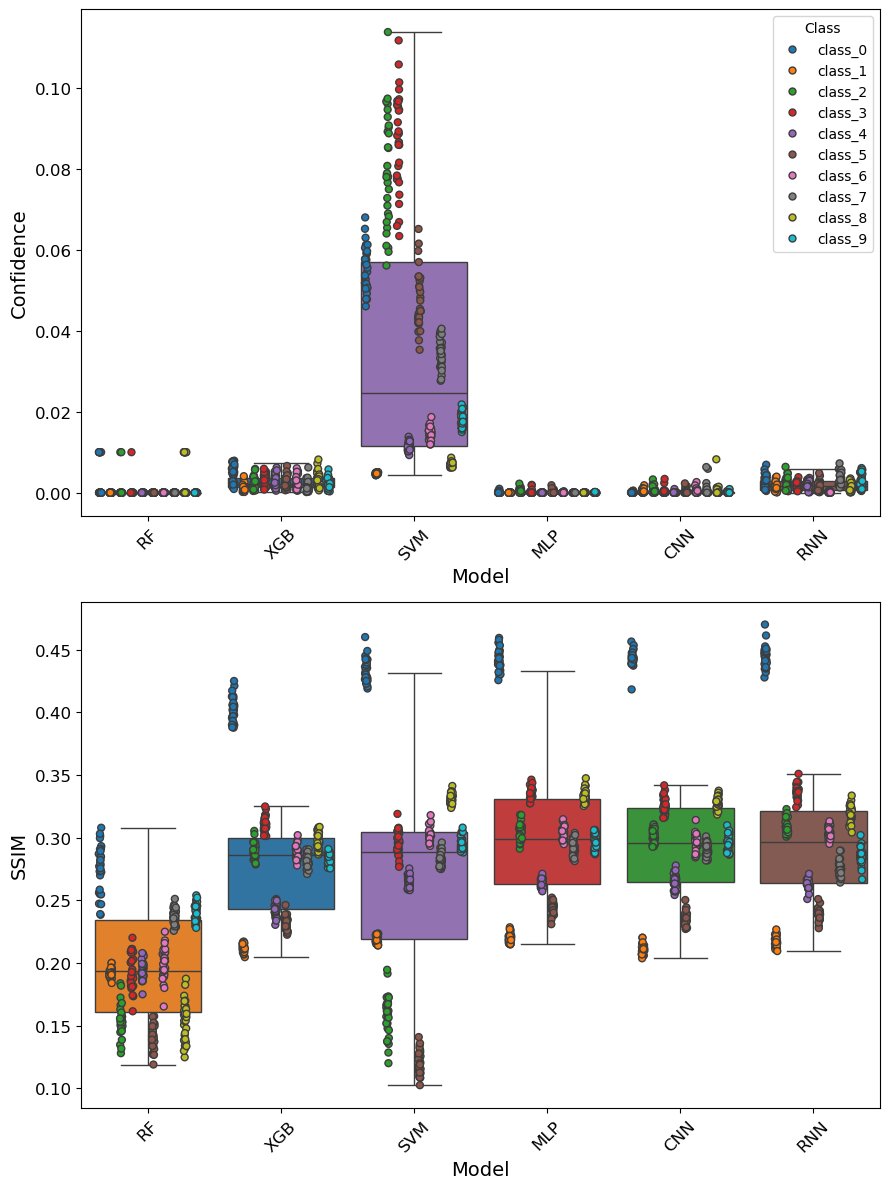

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_mnistDigits_aggregated.csv")

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

# Keep only relevant columns
data = data[["Model", "Class", "Generation"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Plot the boxplots and stripplots
plt.figure(figsize=(9, 12))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(2, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


Kruskal-Wallis p-value for Confidence (Target Class): 0.00e+00
Kruskal-Wallis p-value for SSIM (Target Class): 2.70e-111


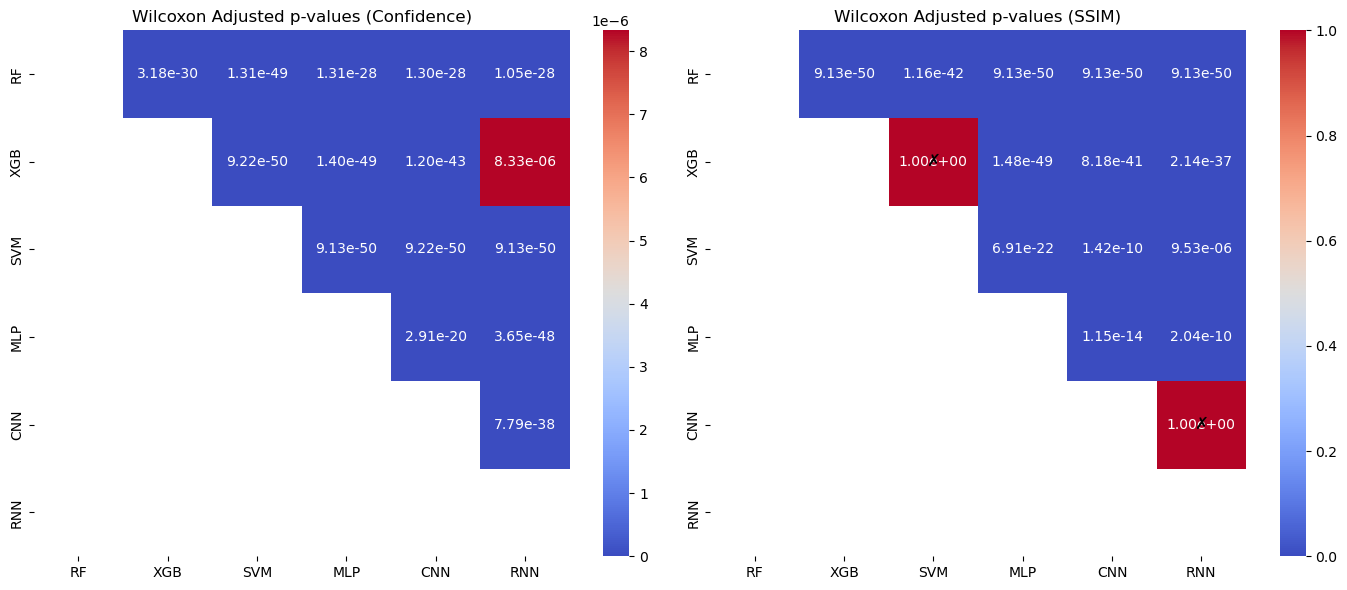

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data_path = "/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_mnistDigits_aggregated.csv"
data = pd.read_csv(data_path)


# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = ["Confidence", "SSIM"]  # Shorter names for visualization

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionaries to store results for Kruskal-Wallis and Wilcoxon
heatmap_data_kruskal = {}
heatmap_data_wilcoxon = {}

# Perform Kruskal-Wallis test first, then Wilcoxon tests
for metric in target_metrics:
    # Kruskal-Wallis test across all models
    grouped_data = [data[data["Model"] == model][metric].dropna() for model in model_order]
    
    # Perform Kruskal-Wallis test
    stat, p_kruskal = kruskal(*grouped_data, nan_policy='omit')
    
    # Store Kruskal-Wallis results in a dictionary
    heatmap_data_kruskal[metric] = p_kruskal

    # Wilcoxon pairwise comparisons
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust Wilcoxon p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix for heatmap visualization
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix

# Display Kruskal-Wallis test results
for metric, p_value in heatmap_data_kruskal.items():
    print(f"Kruskal-Wallis p-value for {metric}: {p_value:.2e}")

# Plot the Wilcoxon heatmaps with significance markers (✗ for p ≥ 0.05)
fig, axes = plt.subplots(1, len(target_metrics), figsize=(14, 6))

for i, (metric, alias) in enumerate(zip(target_metrics, metric_aliases)):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    
    # Add ✗ marks for non-significant p-values (p ≥ 0.05)
    for x in range(len(model_order)):
        for y in range(x + 1, len(model_order)):  # Only upper triangle
            if not np.isnan(heatmap_data_wilcoxon[metric][x, y]) and heatmap_data_wilcoxon[metric][x, y] >= 0.05:
                ax.text(y + 0.5, x + 0.5, "✗", ha="center", va="center", fontsize=12, color="black", fontweight="bold")

    ax.set_title(f"Wilcoxon Adjusted p-values ({alias})")

plt.tight_layout()
plt.show()


## x mnistFashion

Average Generation: 98020.90611111111
Average Generation is not 100000. Details:
Number of instances: 55
      Generation Model    Class     Replicate
10         17550   XGB  class_7  replicate_10
13         17612   XGB  class_7   replicate_9
19         72761   XGB  class_7   replicate_1
100         4690   XGB  class_8  replicate_10
102        12662   XGB  class_8   replicate_4
108        12687   XGB  class_8   replicate_6
109        17868   XGB  class_8   replicate_1
110        12691   XGB  class_8   replicate_3
114        12580   XGB  class_8   replicate_5
116        17825   XGB  class_8   replicate_2
121        56790   XGB  class_4   replicate_7
129        68994   XGB  class_4   replicate_8
130        68641   XGB  class_4  replicate_10
133        68645   XGB  class_4   replicate_9
181        15940   XGB  class_6   replicate_7
189        71880   XGB  class_6   replicate_8
190        72256   XGB  class_6  replicate_10
193        72706   XGB  class_6   replicate_9
211        61455   XG

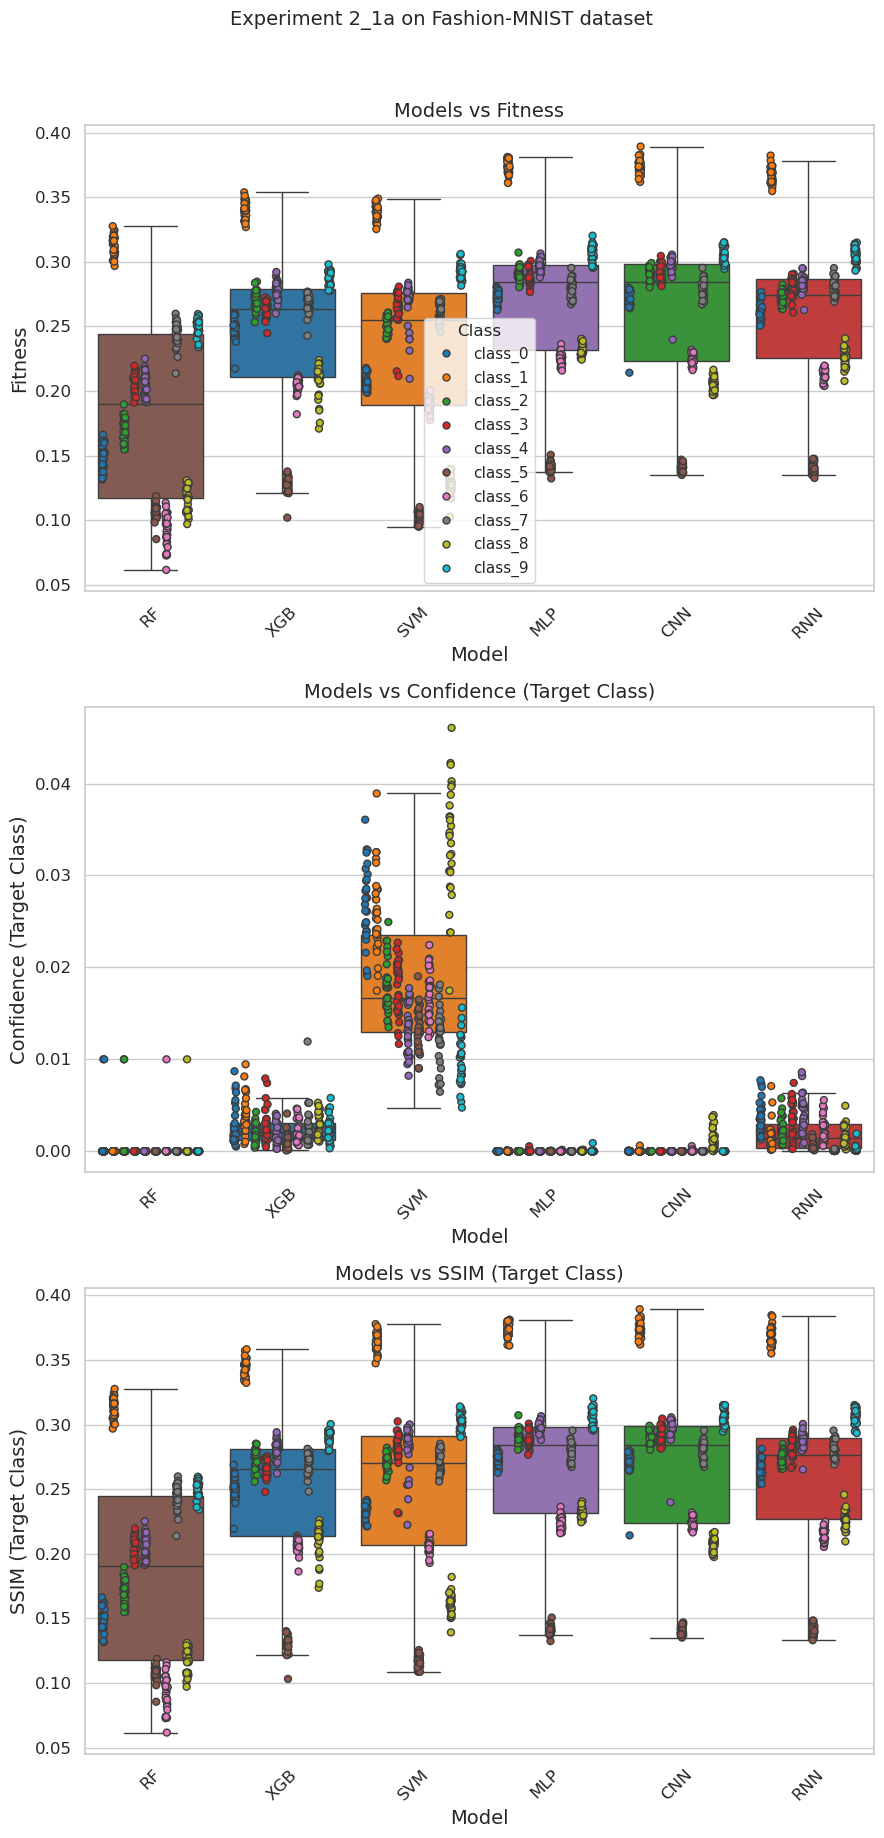

In [125]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_mnistFashion_aggregated.csv")
experiment = "2_1a"
dataset = "Fashion-MNIST"

# Filter relevant columns (target class metrics)
target_metrics = ["Fitness", "Confidence (Target Class)", "SSIM (Target Class)"]
num_metrics = len(target_metrics)

custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

data = data[["Model", "Class", "Generation" , "Replicate"] + target_metrics]
print("Average Generation:", data["Generation"].mean())
# Check if the average generation is not 100000 and print the relevant info
if not np.isclose(data["Generation"].mean(), 100000):
    print("Average Generation is not 100000. Details:")
    print(f"Number of instances: {len(data[~np.isclose(data['Generation'], 100000)])}")
    print(data[["Generation", "Model", "Class", "Replicate"]][~np.isclose(data["Generation"], 100000)])


# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Create strip plots for each metric with superimposed box plots
plt.figure(figsize=(3 * num_metrics, 6 * num_metrics))  # Adjust figure size for better visualization
for i, metric in enumerate(target_metrics, 1):
    plt.subplot(num_metrics, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.title(f"Models vs {metric}", fontsize=14)  # Adjust title fontsize
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class')  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

# Set the suptitle with proper alignment and spacing
plt.suptitle(f"Experiment {experiment} on {dataset} dataset", 
             fontsize=14, y=1.02, ha='center')  # Higher fontsize and adjusted 'y' position
plt.tight_layout()  # Adjust layout to ensure the plots fit below the suptitle

plt.show()



# Experiment 2_1b

## sklearnDigits

Average Generation: 50000.0


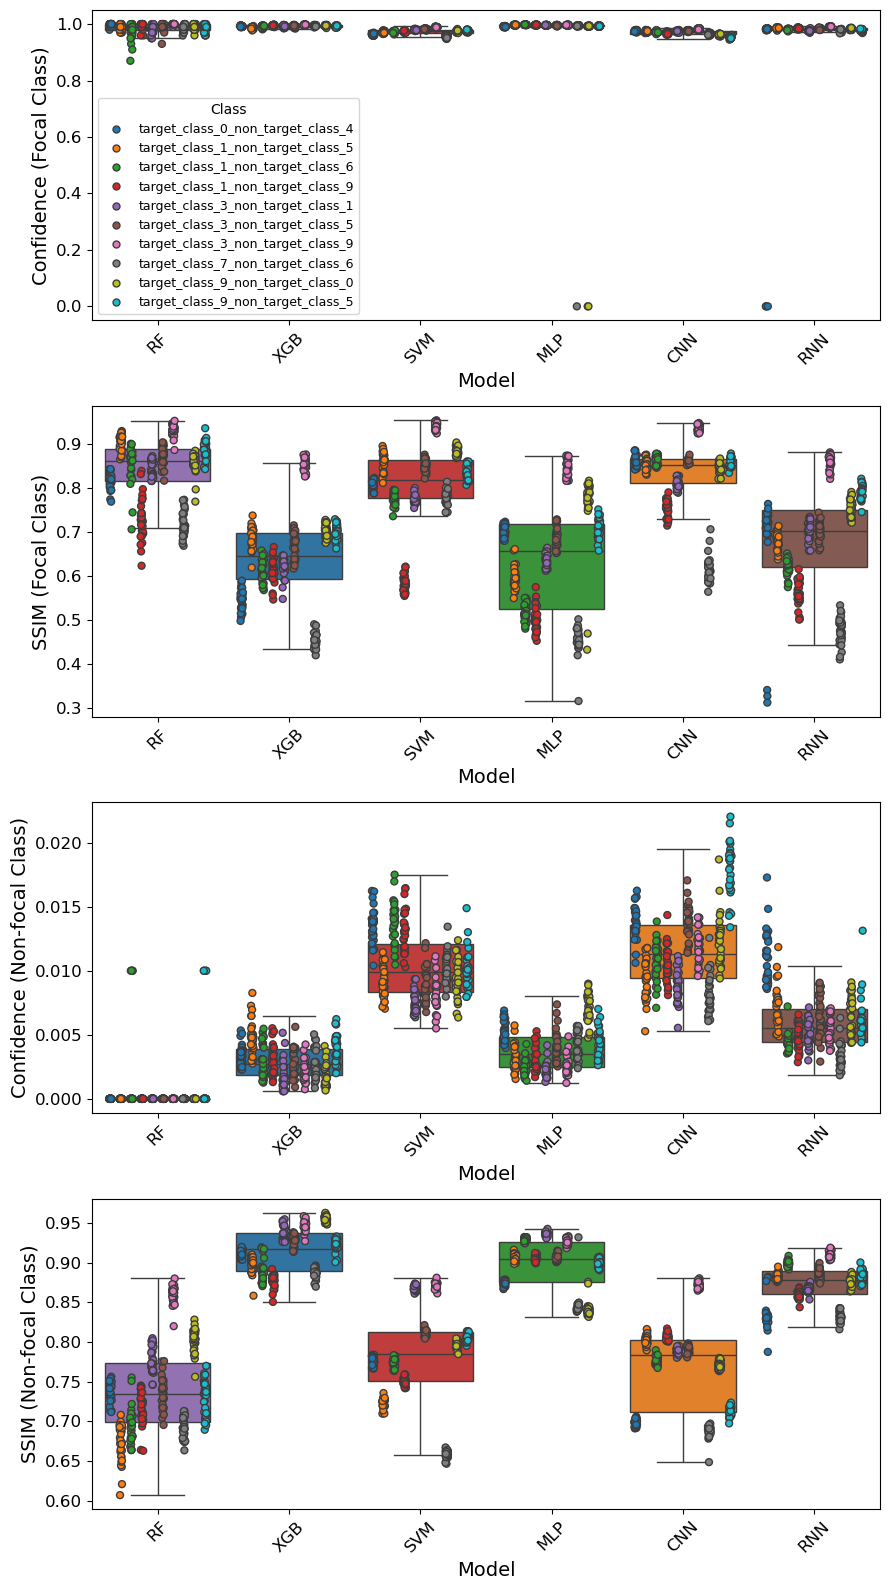

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_sklearnDigits_aggregated.csv")

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)", 
                  "Confidence (Similarity Class)", "SSIM (Similarity Class)"]
metric_aliases = ["Confidence (Focal Class)", "SSIM (Focal Class)", 
                  "Confidence (Non-focal Class)", "SSIM (Non-focal Class)"]

# Rename the columns using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

num_metrics = len(renamed_metrics)

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
                  "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
                  "#bcbd22", "#17becf"]

# Keep only the relevant columns
data = data[["Model", "Class", "Generation", "Replicate"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Check if the average generation is not 50000 and print the relevant info
if not np.isclose(data["Generation"].mean(), 50000):
    print("Average Generation is not 50000. Details:")
    print(f"Number of instances: {len(data[~np.isclose(data['Generation'], 50000)])}")
    print(data[["Generation", "Model", "Class", "Replicate"]][~np.isclose(data["Generation"], 50000)])

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Create strip plots for each metric with superimposed box plots
plt.figure(figsize=(9, 4 * num_metrics))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(num_metrics, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class', fontsize=9)  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


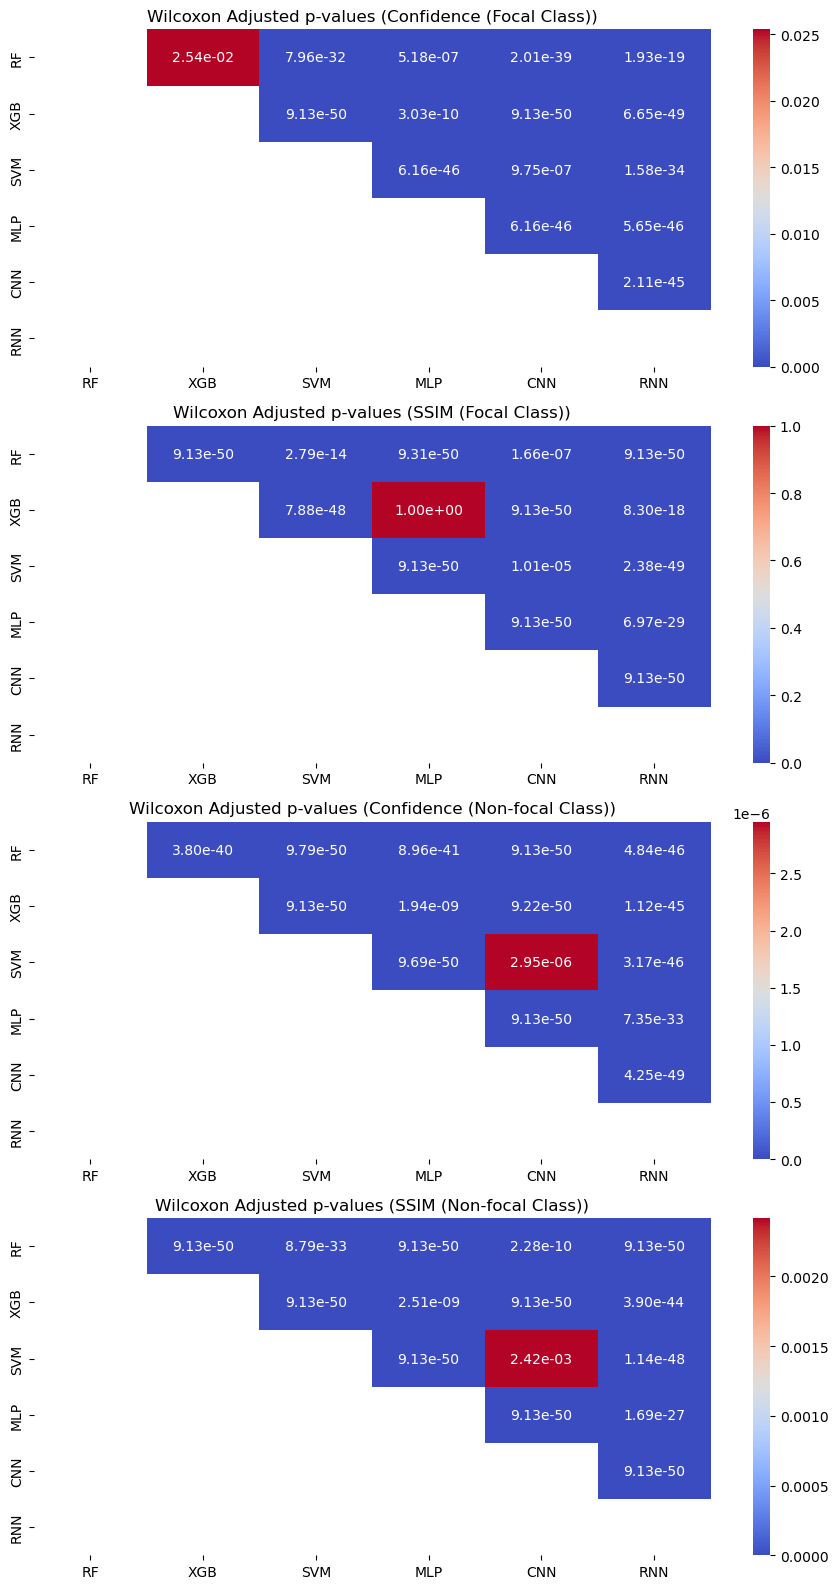


Kruskal-Wallis Test Results:
Confidence (Focal Class): p-value = 2.8008e-249
SSIM (Focal Class): p-value = 2.9929e-175
Confidence (Non-focal Class): p-value = 0.0000e+00
SSIM (Non-focal Class): p-value = 4.8254e-282


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_sklearnDigits_aggregated.csv")
experiment = "2_1b"
dataset = "sklearn (digits)"

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)", 
                  "Confidence (Similarity Class)", "SSIM (Similarity Class)"]
metric_aliases = ["Confidence (Focal Class)", "SSIM (Focal Class)", 
                  "Confidence (Non-focal Class)", "SSIM (Non-focal Class)"]  # Aliases for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionary to store results
heatmap_data_wilcoxon = {}
heatmap_data_kruskal = {}

# Perform Wilcoxon and Kruskal-Wallis tests
for metric in renamed_metrics:
    pairs = list(combinations(model_order, 2))
    p_values_wilcoxon = []
    
    # Wilcoxon test for pairwise comparisons
    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values_wilcoxon.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values_wilcoxon.append(p)
            except ValueError:
                p_values_wilcoxon.append(np.nan)

    # Adjust p-values for multiple comparisons using Bonferroni correction
    adjusted_p_values_wilcoxon = multipletests([p if not np.isnan(p) else 1 for p in p_values_wilcoxon], method="bonferroni")[1]

    # Convert Wilcoxon results to an upper triangle matrix
    n_models = len(model_order)
    p_matrix_wilcoxon = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix_wilcoxon[i, j] = adjusted_p_values_wilcoxon[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix_wilcoxon

    # Kruskal-Wallis test for overall comparison
    samples = [data[data["Model"] == model][metric].dropna() for model in model_order]
    _, p_kruskal = kruskal(*samples)
    heatmap_data_kruskal[metric] = p_kruskal

# Plot the Wilcoxon heatmaps
fig, axes = plt.subplots(len(renamed_metrics), 1, figsize=(9, 4 * len(renamed_metrics)))

for i, metric in enumerate(renamed_metrics):
    ax = axes[i] if len(renamed_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    ax.set_title(f"Wilcoxon Adjusted p-values ({metric})")

plt.tight_layout()
plt.show()

# Print Kruskal-Wallis p-values
print("\nKruskal-Wallis Test Results:")
for metric, p_val in heatmap_data_kruskal.items():
    print(f"{metric}: p-value = {p_val:.4e}")


## mnistDigits


Average Generation: 100000.0


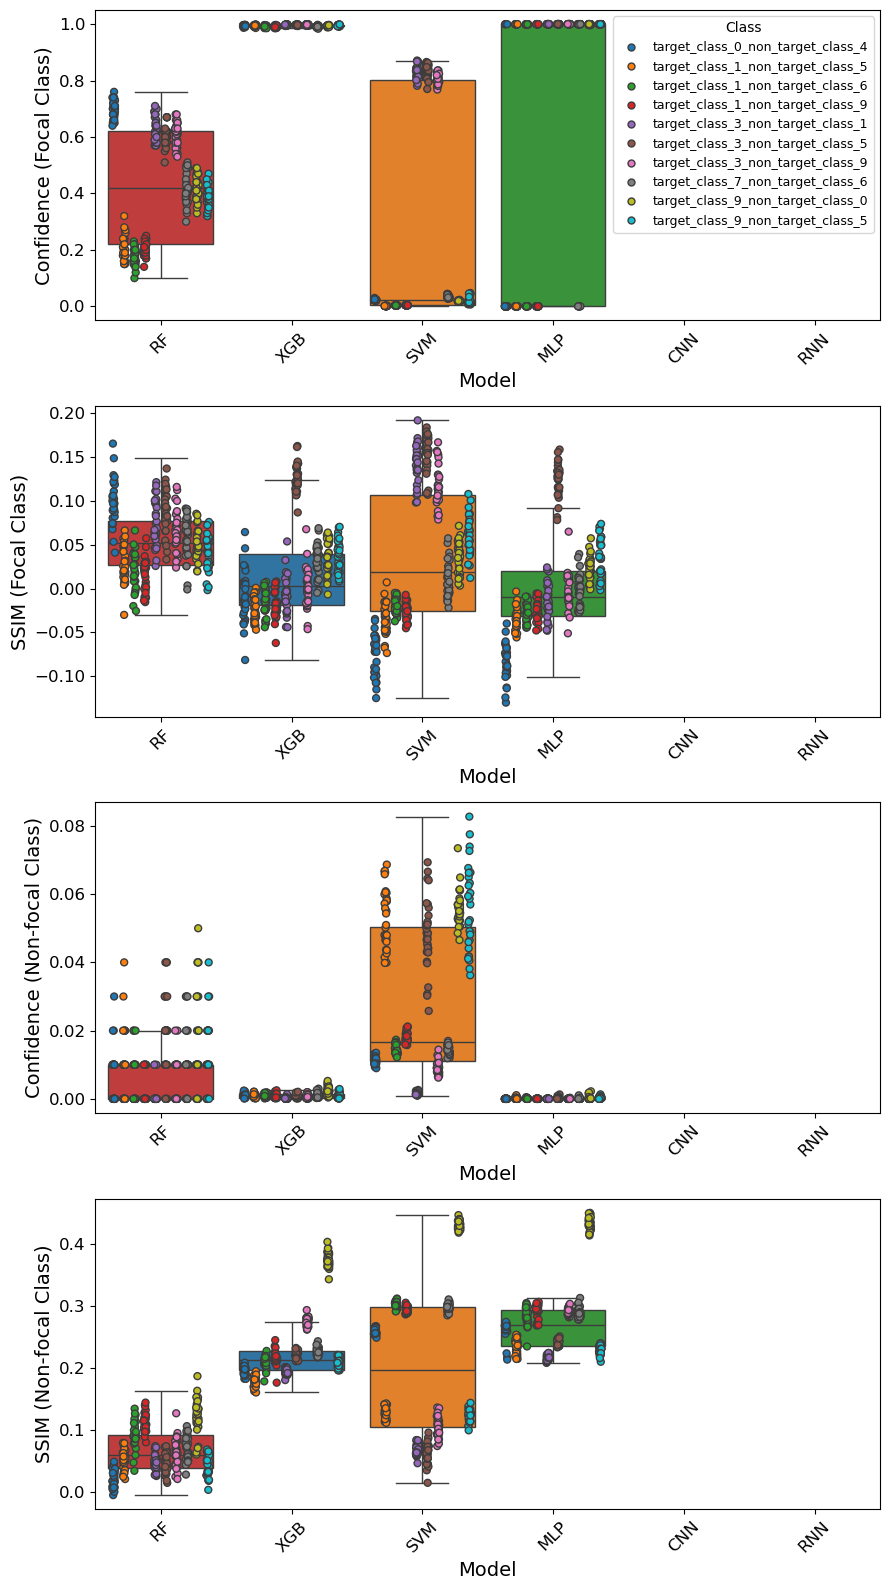

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_mnistDigits_aggregated.csv")

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)", 
                  "Confidence (Similarity Class)", "SSIM (Similarity Class)"]
metric_aliases = ["Confidence (Focal Class)", "SSIM (Focal Class)", 
                  "Confidence (Non-focal Class)", "SSIM (Non-focal Class)"]

# Rename the columns using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

num_metrics = len(renamed_metrics)

# Define custom color palette
custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", 
                  "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", 
                  "#bcbd22", "#17becf"]

# Keep only the relevant columns
data = data[["Model", "Class", "Generation", "Replicate"] + renamed_metrics]

print("Average Generation:", data["Generation"].mean())

# Check if the average generation is not 100000 and print the relevant info
if not np.isclose(data["Generation"].mean(), 100000):
    print("Average Generation is not 100000. Details:")
    print(f"Number of instances: {len(data[~np.isclose(data['Generation'], 100000)])}")
    print(data[["Generation", "Model", "Class", "Replicate"]][~np.isclose(data["Generation"], 100000)])

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]

# Create strip plots for each metric with superimposed box plots
plt.figure(figsize=(9, 4 * num_metrics))  # Adjust figure size for better visualization
for i, metric in enumerate(renamed_metrics, 1):
    plt.subplot(num_metrics, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class', fontsize=9)  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

plt.tight_layout()  # Adjust layout to ensure the plots fit properly

plt.show()


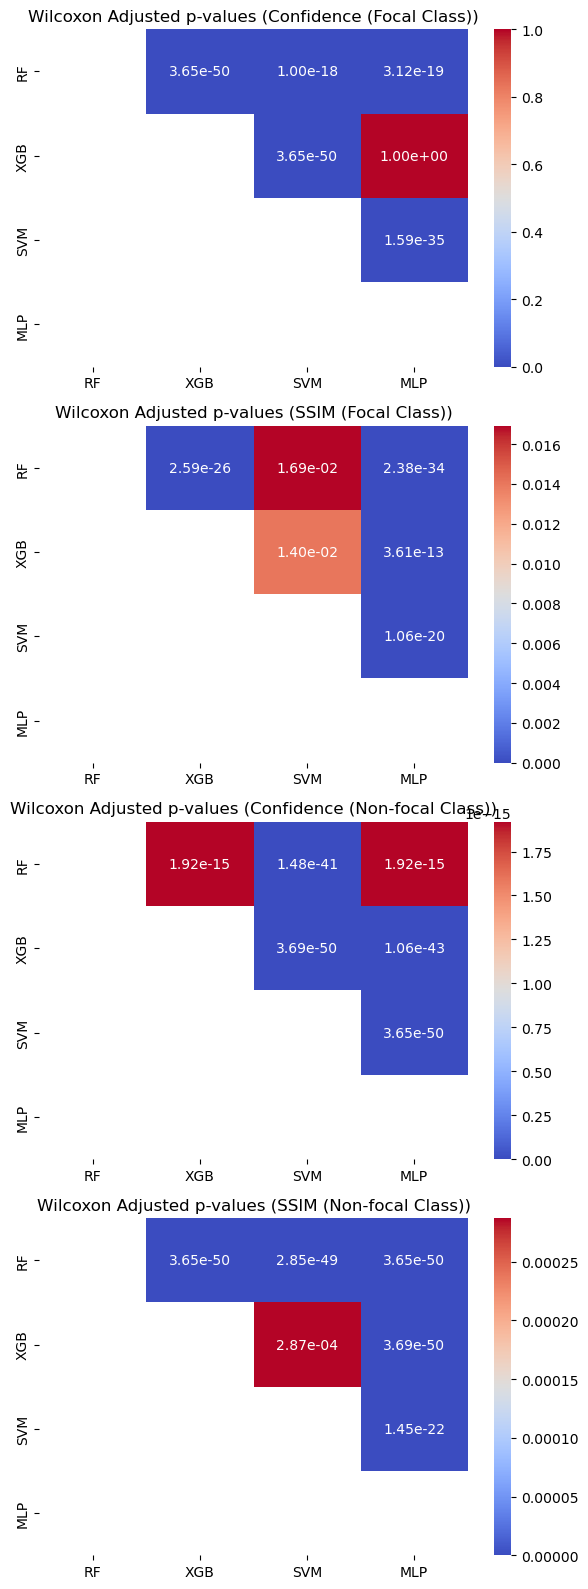

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_mnistDigits_aggregated.csv")
experiment = "2_1b"
dataset = "mnist (digits)"

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)", 
                  "Confidence (Similarity Class)", "SSIM (Similarity Class)"]
metric_aliases = ["Confidence (Focal Class)", "SSIM (Focal Class)", 
                  "Confidence (Non-focal Class)", "SSIM (Non-focal Class)"]  # Aliases for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionary to store results
heatmap_data = {}

# Perform Wilcoxon tests and store results
for metric in renamed_metrics:
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data[metric] = p_matrix

# Plot the heatmaps
fig, axes = plt.subplots(len(renamed_metrics), 1, figsize=(6, 4 * len(renamed_metrics)))

for i, metric in enumerate(renamed_metrics):
    ax = axes[i] if len(renamed_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data[metric], dtype=bool))
    sns.heatmap(heatmap_data[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    ax.set_title(f"Wilcoxon Adjusted p-values ({metric})")

plt.tight_layout()
plt.show()


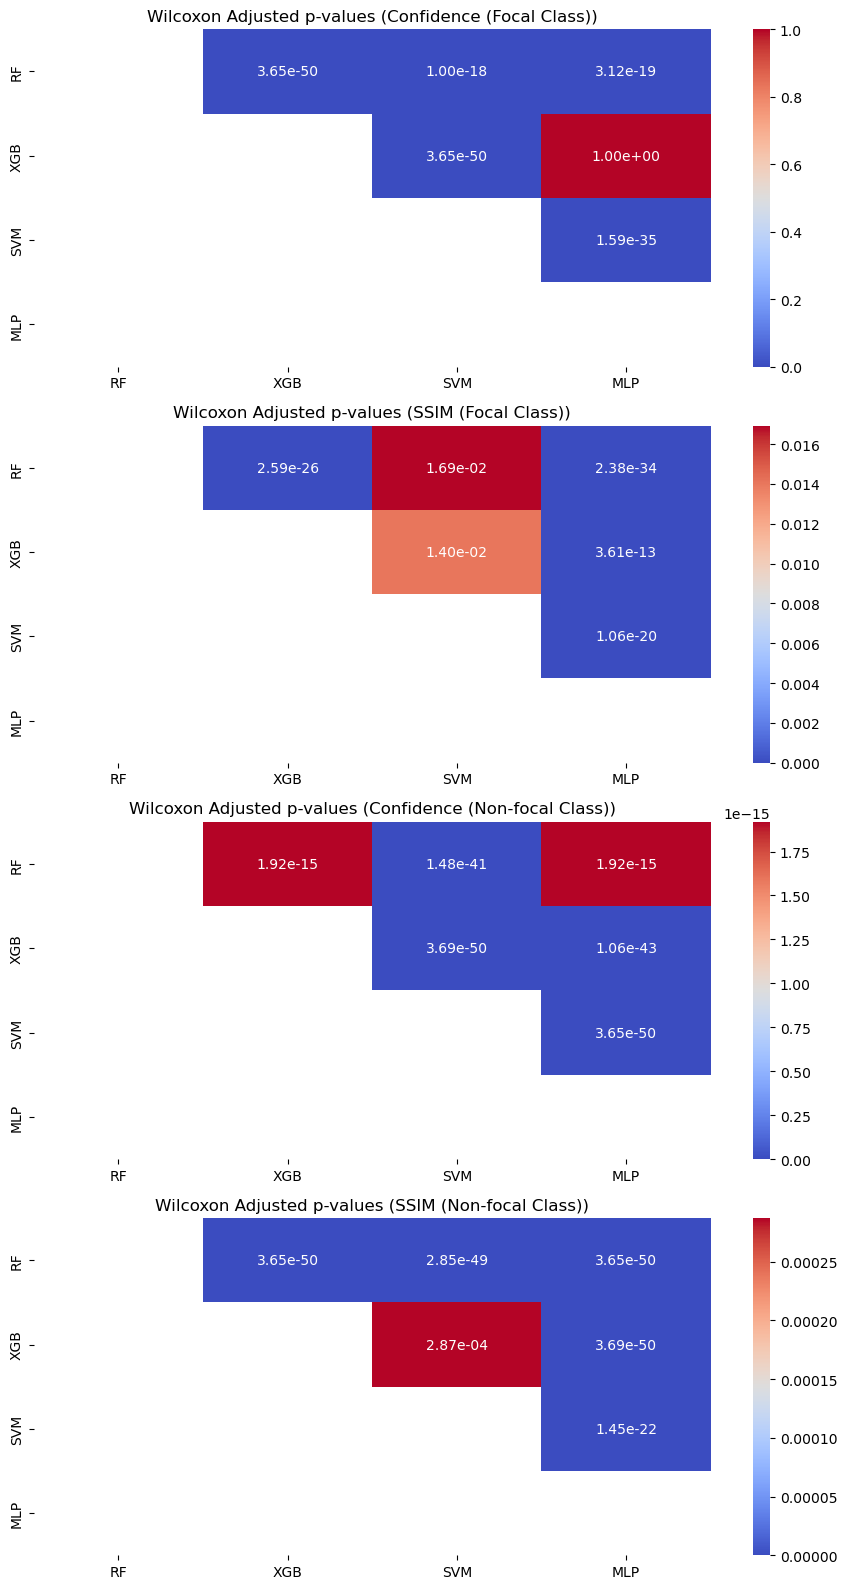


Kruskal-Wallis Test Results:
Confidence (Focal Class): p-value = 3.3912e-104
SSIM (Focal Class): p-value = 6.3756e-41
Confidence (Non-focal Class): p-value = 6.8763e-132
SSIM (Non-focal Class): p-value = 2.8655e-139


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon, kruskal
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_mnistDigits_aggregated.csv")
experiment = "2_1b"
dataset = "mnist (digits)"

# Define target metrics and their aliases
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)", 
                  "Confidence (Similarity Class)", "SSIM (Similarity Class)"]
metric_aliases = ["Confidence (Focal Class)", "SSIM (Focal Class)", 
                  "Confidence (Non-focal Class)", "SSIM (Non-focal Class)"]  # Aliases for visualization

# Rename target metrics using aliases
alias_mapping = dict(zip(target_metrics, metric_aliases))
data = data.rename(columns=alias_mapping)
renamed_metrics = list(alias_mapping.values())

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionary to store results
heatmap_data_wilcoxon = {}
heatmap_data_kruskal = {}

# Perform Wilcoxon and Kruskal-Wallis tests
for metric in renamed_metrics:
    pairs = list(combinations(model_order, 2))
    p_values_wilcoxon = []
    
    # Wilcoxon test for pairwise comparisons
    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values_wilcoxon.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values_wilcoxon.append(p)
            except ValueError:
                p_values_wilcoxon.append(np.nan)

    # Adjust p-values for multiple comparisons using Bonferroni correction
    adjusted_p_values_wilcoxon = multipletests([p if not np.isnan(p) else 1 for p in p_values_wilcoxon], method="bonferroni")[1]

    # Convert Wilcoxon results to an upper triangle matrix
    n_models = len(model_order)
    p_matrix_wilcoxon = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix_wilcoxon[i, j] = adjusted_p_values_wilcoxon[index]
            index += 1

    heatmap_data_wilcoxon[metric] = p_matrix_wilcoxon

    # Kruskal-Wallis test for overall comparison
    samples = [data[data["Model"] == model][metric].dropna() for model in model_order]
    _, p_kruskal = kruskal(*samples)
    heatmap_data_kruskal[metric] = p_kruskal

# Plot the Wilcoxon heatmaps
fig, axes = plt.subplots(len(renamed_metrics), 1, figsize=(9, 4 * len(renamed_metrics)))

for i, metric in enumerate(renamed_metrics):
    ax = axes[i] if len(renamed_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data_wilcoxon[metric], dtype=bool))
    sns.heatmap(heatmap_data_wilcoxon[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    ax.set_title(f"Wilcoxon Adjusted p-values ({metric})")

plt.tight_layout()
plt.show()

# Print Kruskal-Wallis p-values
print("\nKruskal-Wallis Test Results:")
for metric, p_val in heatmap_data_kruskal.items():
    print(f"{metric}: p-value = {p_val:.4e}")


## x mnistFashion


Average Generation: 99986.77416666667
Average Generation is not 100000. Details:
Number of instances: 2
     Generation Model                              Class     Replicate
344       85129   SVM  target_class_9_non_target_class_5  replicate_29
564       99000   SVM  target_class_1_non_target_class_5   replicate_5


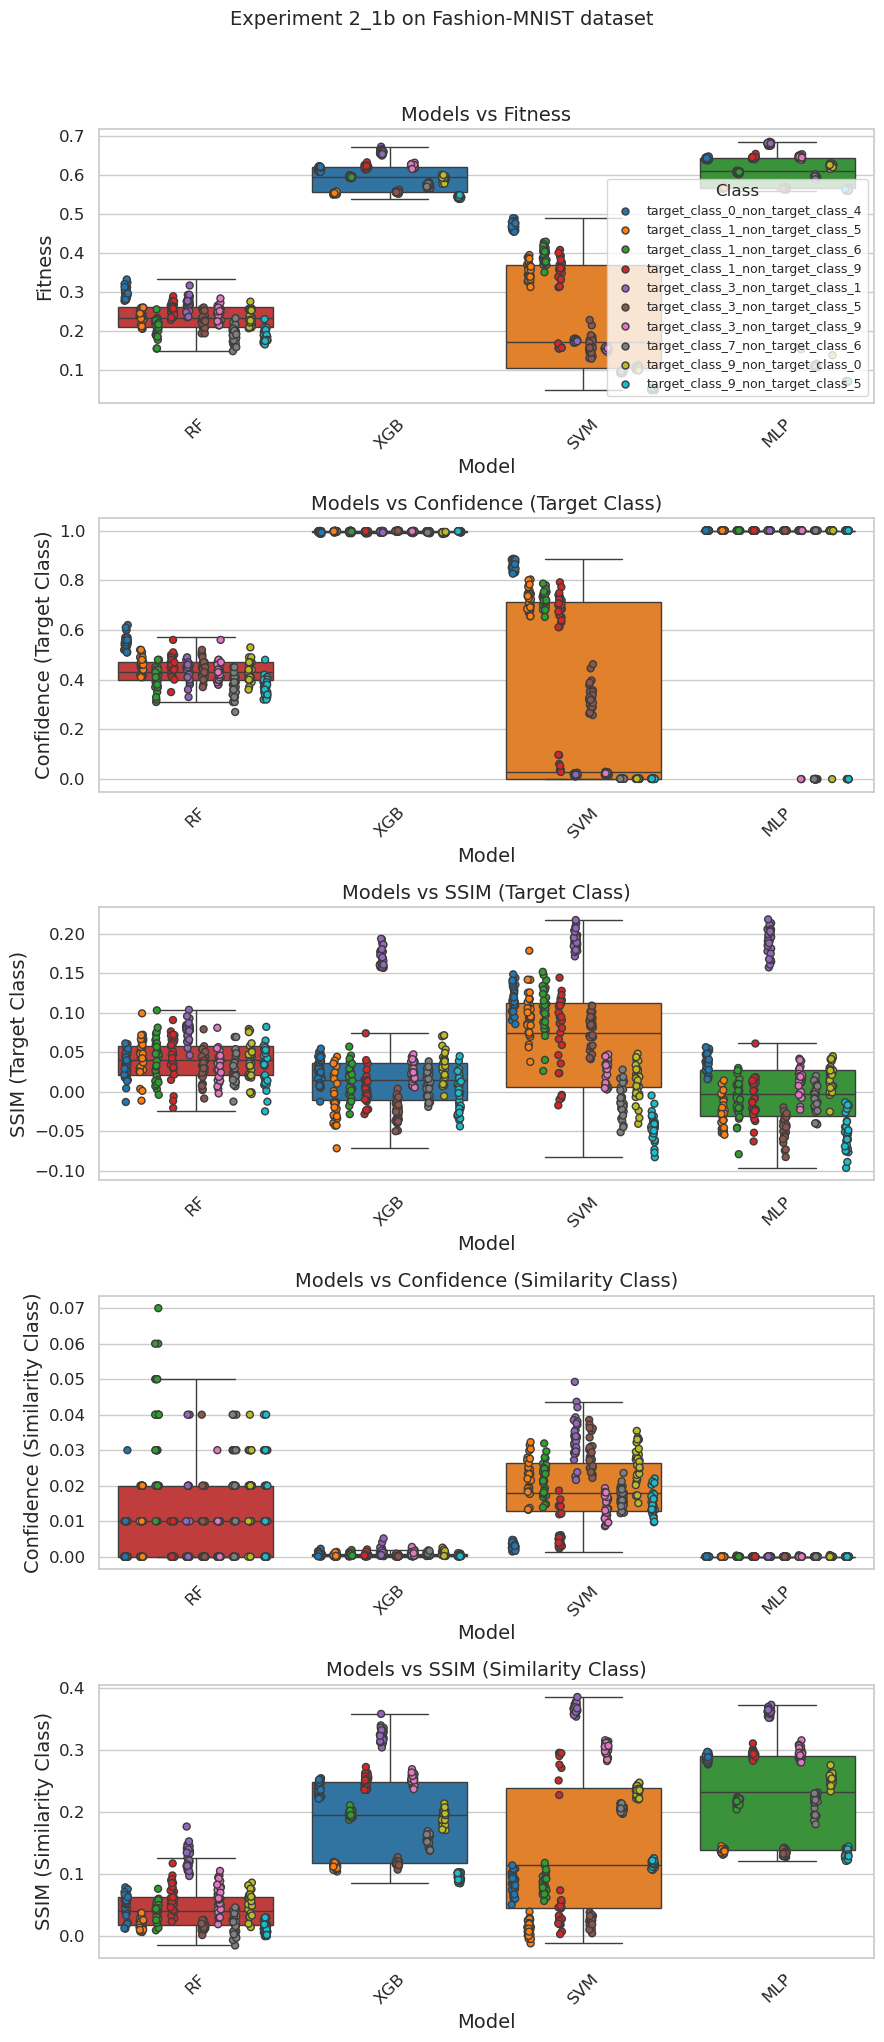

In [110]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_mnistfashion_aggregated.csv")
experiment = "2_1b"
dataset = "Fashion-MNIST"

# Filter relevant columns (target class metrics)
target_metrics = ["Fitness", "Confidence (Target Class)", "SSIM (Target Class)", "Confidence (Similarity Class)", "SSIM (Similarity Class)"]

num_metrics = len(target_metrics)

custom_palette = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

data = data[["Model", "Class", "Generation" , "Replicate"] + target_metrics]

print("Average Generation:", data["Generation"].mean())

# Check if the average generation is not 50000 and print the relevant info
if not np.isclose(data["Generation"].mean(), 100000):
    print("Average Generation is not 100000. Details:")
    print(f"Number of instances: {len(data[~np.isclose(data['Generation'], 100000)])}")
    print(data[["Generation", "Model", "Class", "Replicate"]][~np.isclose(data["Generation"], 100000)])

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Define the order for the models on the x-axis
model_order = ["RF", "XGB", "SVM", "MLP"]

# Create strip plots for each metric with superimposed box plots
plt.figure(figsize=(9, 4 * num_metrics))  # Adjust figure size for better visualization
for i, metric in enumerate(target_metrics, 1):
    plt.subplot(num_metrics, 1, i)
    sns.boxplot(x="Model", y=metric, data=data, hue="Model", 
                palette=custom_palette[:len(data["Model"].unique())], 
                showfliers=False, order=model_order, dodge=False)  # Add box plot
    sns.stripplot(x="Model", y=metric, data=data, hue="Class", 
                  palette=custom_palette, jitter=True, dodge=True, linewidth=1, 
                  edgecolor='auto', order=model_order)  # Add strip plot
    plt.title(f"Models vs {metric}", fontsize=14)  # Adjust title fontsize
    plt.xlabel("Model", fontsize=14)  # Increase x-axis title fontsize
    plt.ylabel(metric, fontsize=14)  # Increase y-axis title fontsize
    plt.xticks(rotation=45)  # Rotate model names for better readability
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if i == 1:
        plt.legend(title='Class', fontsize=9)  # Ensure legend for the first subplot
    else:
        plt.legend().remove()  # Remove legend for subplots after the first one to avoid redundancy

# Set the suptitle with proper alignment and spacing
plt.suptitle(f"Experiment {experiment} on {dataset} dataset", 
             fontsize=14, y=1.02, ha='center')  # Higher fontsize and adjusted 'y' position
plt.tight_layout()  # Adjust layout to ensure the plots fit below the suptitle

plt.show()



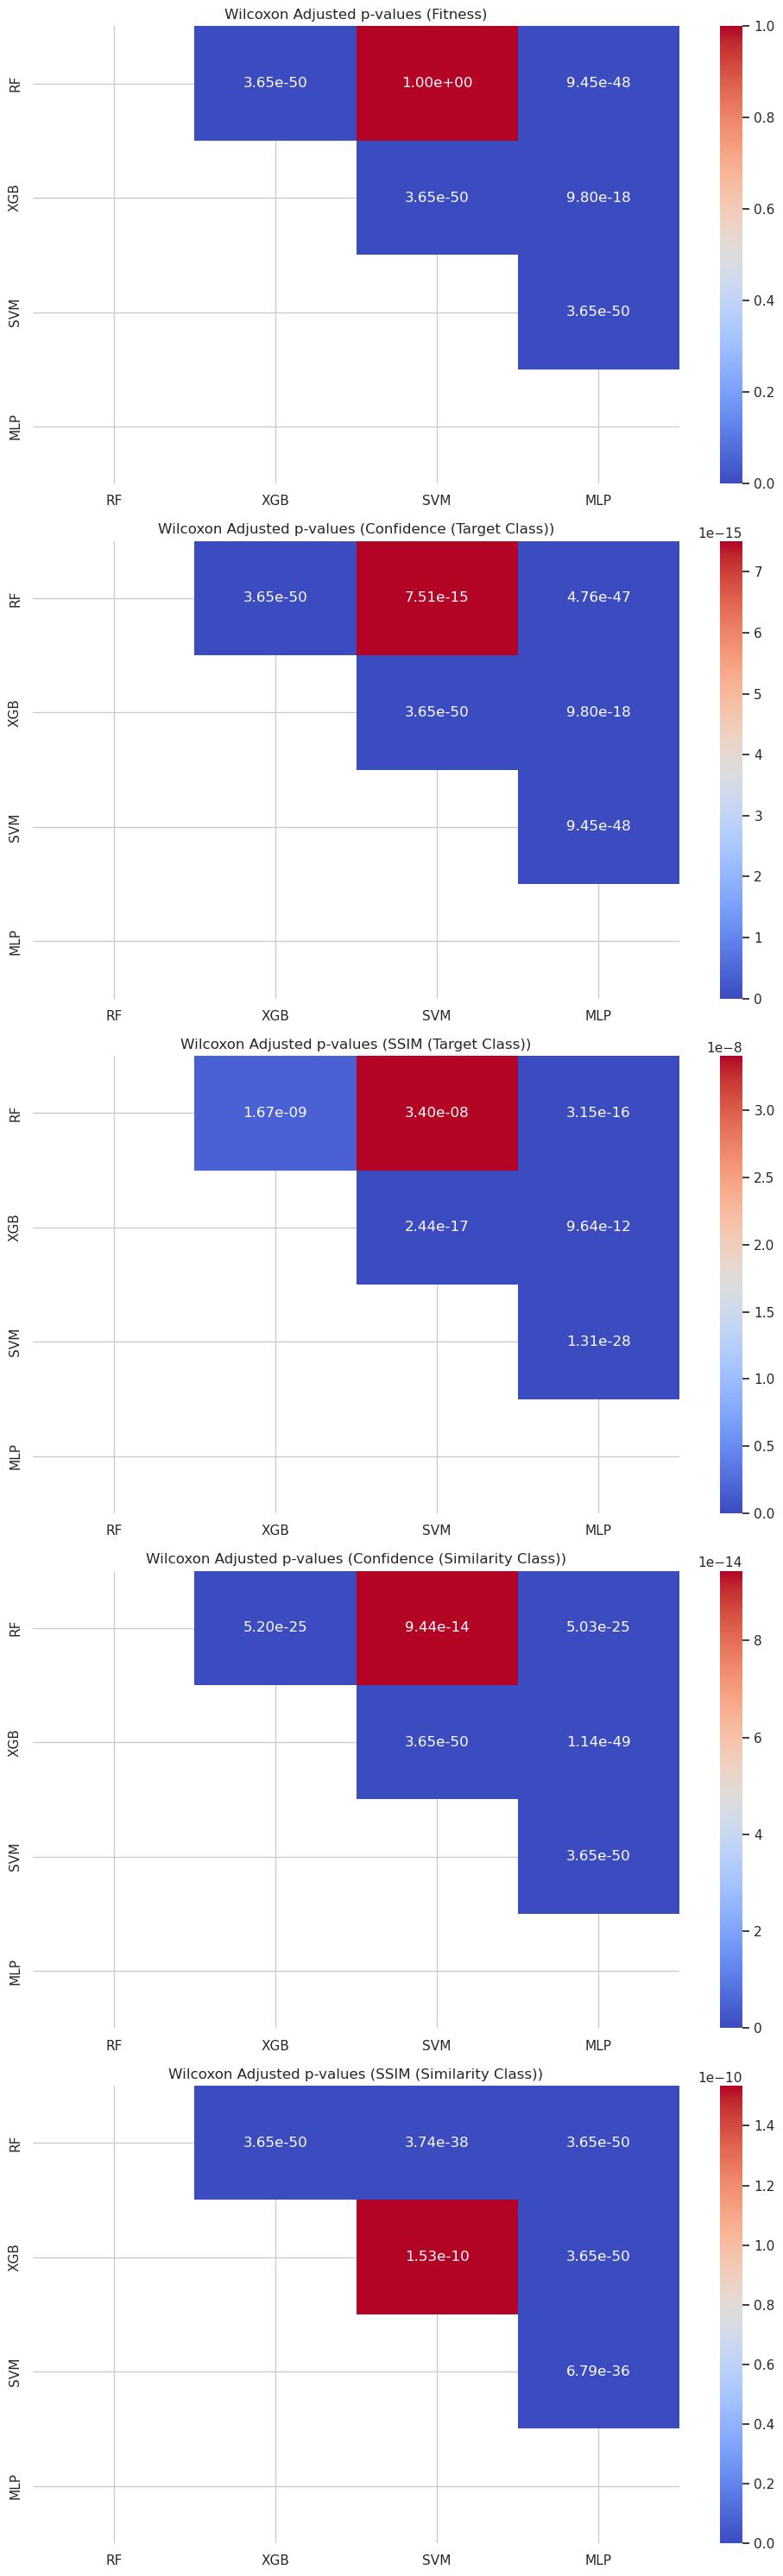

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Load the data
data = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_mnistFashion_aggregated.csv")
experiment = "2_1b"
dataset = "Fashion-MNIST"

# Define target metrics
target_metrics = ["Fitness", "Confidence (Target Class)", "SSIM (Target Class)", "Confidence (Similarity Class)", "SSIM (Similarity Class)"]

# Define the model order
model_order = ["RF", "XGB", "SVM", "MLP"]

# Ensure classes are ordered alphabetically
data['Class'] = pd.Categorical(data['Class'], categories=sorted(data['Class'].unique()), ordered=True)

# Initialize dictionary to store results
heatmap_data = {}

# Perform Wilcoxon tests and store results
for metric in target_metrics:
    pairs = list(combinations(model_order, 2))
    p_values = []

    for model1, model2 in pairs:
        group1 = data[data["Model"] == model1][metric].dropna()
        group2 = data[data["Model"] == model2][metric].dropna()

        if len(group1) != len(group2) or len(group1) == 0:
            p_values.append(np.nan)
        else:
            try:
                stat, p = wilcoxon(group1, group2)
                p_values.append(p)
            except ValueError:
                p_values.append(np.nan)

    # Adjust p-values for multiple comparisons
    adjusted_p_values = multipletests([p if not np.isnan(p) else 1 for p in p_values], method="bonferroni")[1]

    # Convert to an upper triangle matrix
    n_models = len(model_order)
    p_matrix = np.full((n_models, n_models), np.nan)
    index = 0
    for i in range(n_models):
        for j in range(i + 1, n_models):
            p_matrix[i, j] = adjusted_p_values[index]
            index += 1

    heatmap_data[metric] = p_matrix

# Plot the heatmaps
fig, axes = plt.subplots(len(target_metrics), 1, figsize=(2*len(target_metrics), 30))

for i, metric in enumerate(target_metrics):
    ax = axes[i] if len(target_metrics) > 1 else axes
    mask = np.tril(np.ones_like(heatmap_data[metric], dtype=bool))
    sns.heatmap(heatmap_data[metric], mask=mask, annot=True, fmt=".2e", cmap="coolwarm",
                xticklabels=model_order, yticklabels=model_order, ax=ax)
    ax.set_title(f"Wilcoxon Adjusted p-values ({metric})")

plt.tight_layout()
plt.show()


# --------------------

# Final 2 Dataset Plots

## Experiment 1

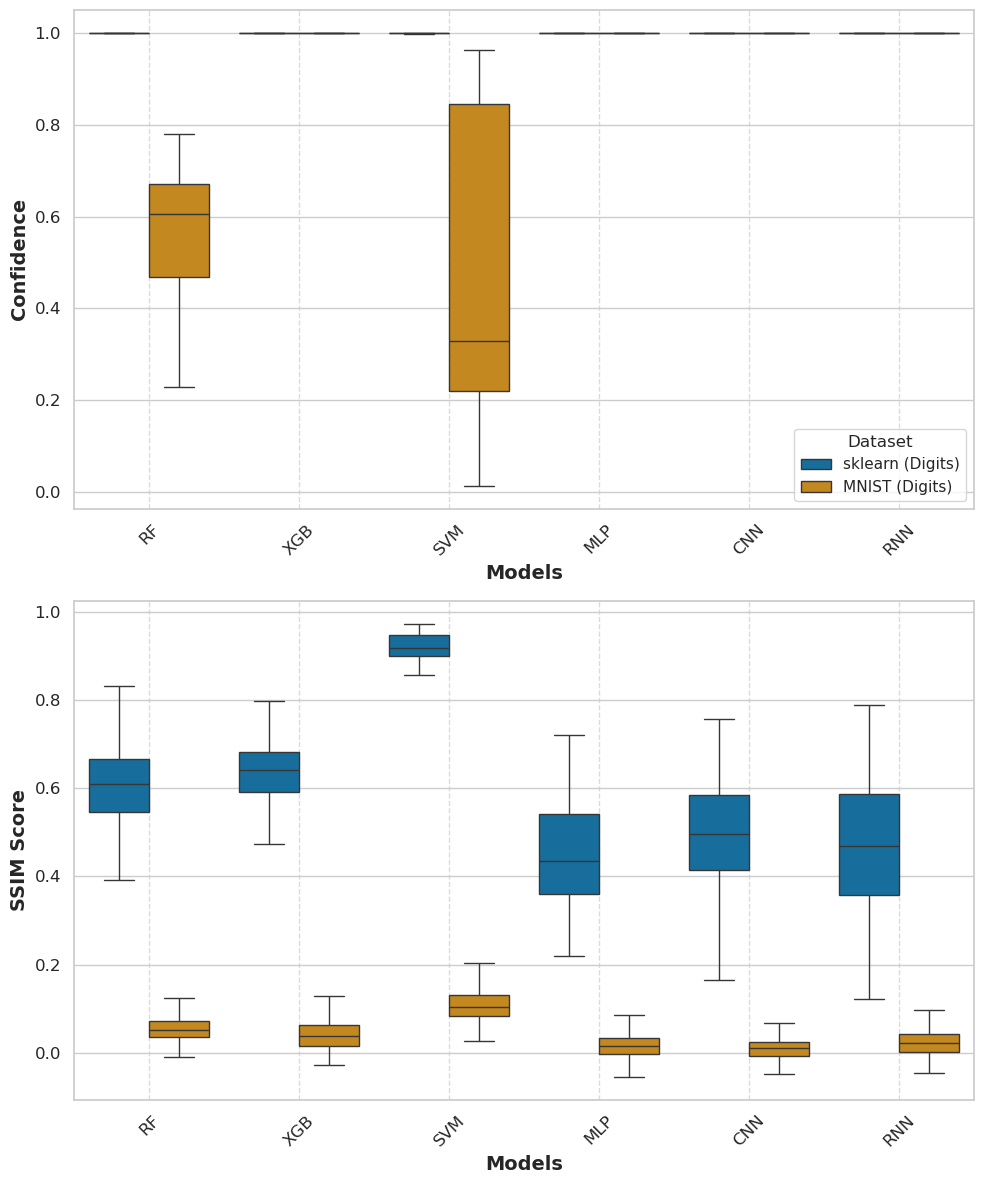

In [94]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data1 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_sklearnDigits_aggregated.csv")
data2 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_mnistDigits_aggregated.csv")
# Assign dataset labels
data1["Dataset"] = "sklearn (Digits)"
data2["Dataset"] = "MNIST (Digits)"

# Combine datasets
data = pd.concat([data1, data2])

# Define relevant columns
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = {"Confidence (Target Class)": "Confidence", "SSIM (Target Class)": "SSIM Score"}
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]
dataset_order = ["sklearn (digits)", "MNIST (digits)", "MNIST (fashion)"]

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

### **Comparison Across Datasets with Correct Strip Plot Alignment** ###
plt.figure(figsize=(10, 12))

for i, metric in enumerate(target_metrics, 1):
    plt.subplot(2, 1, i)
    
    # Boxplot with dodge=True for separation
    sns.boxplot(x="Model", y=metric, hue="Dataset", data=data, 
                palette="colorblind", showfliers=False, order=model_order, dodge=True)

    # Add vertical grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # plt.title(f"Models vs {metric_aliases[metric]} across Datasets", fontsize=14)
    plt.xlabel("Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_aliases[metric], fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    if i == 1:
        plt.legend(title="Dataset")  # Keep dataset legend
    else:
        plt.legend().remove()

plt.tight_layout()
plt.show()


## Experiment 2 (2_2)

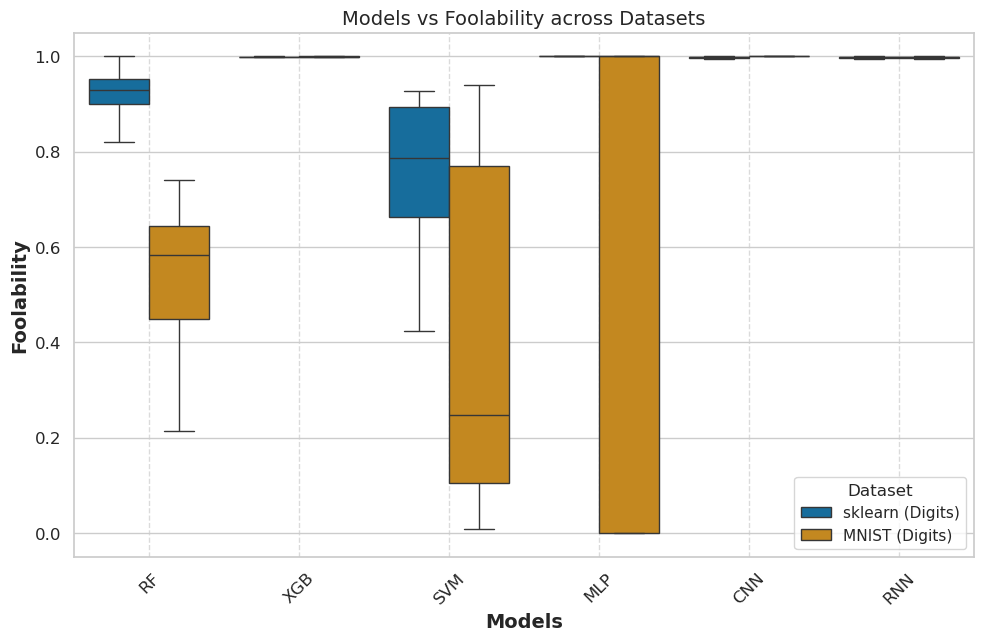

In [93]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data1 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_sklearnDigits_aggregated.csv")
data2 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_mnistDigits_aggregated.csv")
# Assign dataset labels
data1["Dataset"] = "sklearn (Digits)"
data2["Dataset"] = "MNIST (Digits)"

# Combine datasets
data = pd.concat([data1, data2])

# Define relevant columns
target_metrics = ["Fitness"]
metric_aliases = {"Fitness": "Foolability"}
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]
dataset_order = ["sklearn (digits)", "MNIST (digits)", "MNIST (fashion)"]

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

### **Comparison Across Datasets with Correct Strip Plot Alignment** ###
plt.figure(figsize=(10, 12))

for i, metric in enumerate(target_metrics, 1):
    plt.subplot(2, 1, i)
    
    # Boxplot with dodge=True for separation
    sns.boxplot(x="Model", y=metric, hue="Dataset", data=data, 
                palette="colorblind", showfliers=False, order=model_order, dodge=True)

    # Add vertical grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.title(f"Models vs {metric_aliases[metric]} across Datasets", fontsize=14)
    plt.xlabel("Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_aliases[metric], fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    if i == 1:
        plt.legend(title="Dataset")  # Keep dataset legend
    else:
        plt.legend().remove()

plt.tight_layout()
plt.show()


## Experiment 3 (2_1a)

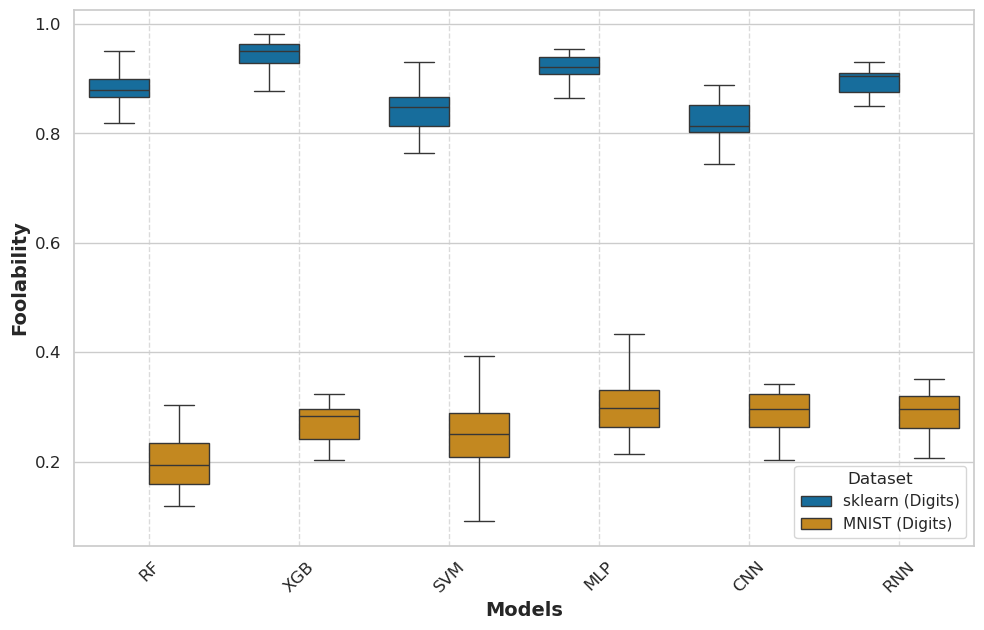

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data1 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_sklearnDigits_aggregated.csv")
data2 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1a_mnistDigits_aggregated.csv")
# Assign dataset labels
data1["Dataset"] = "sklearn (Digits)"
data2["Dataset"] = "MNIST (Digits)"

# Combine datasets
data = pd.concat([data1, data2])

# Define relevant columns
target_metrics = ["Fitness"]
metric_aliases = {"Fitness": "Foolability"}
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]
dataset_order = ["sklearn (digits)", "MNIST (digits)", "MNIST (fashion)"]

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

### **Comparison Across Datasets with Correct Strip Plot Alignment** ###
plt.figure(figsize=(10, 12))

for i, metric in enumerate(target_metrics, 1):
    plt.subplot(2, 1, i)
    
    # Boxplot with dodge=True for separation
    sns.boxplot(x="Model", y=metric, hue="Dataset", data=data, 
                palette="colorblind", showfliers=False, order=model_order, dodge=True)

    # Add vertical grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.xlabel("Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_aliases[metric], fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    if i == 1:
        plt.legend(title="Dataset")  # Keep dataset legend
    else:
        plt.legend().remove()

plt.tight_layout()
plt.show()


## Experiment 4 (2_1b)

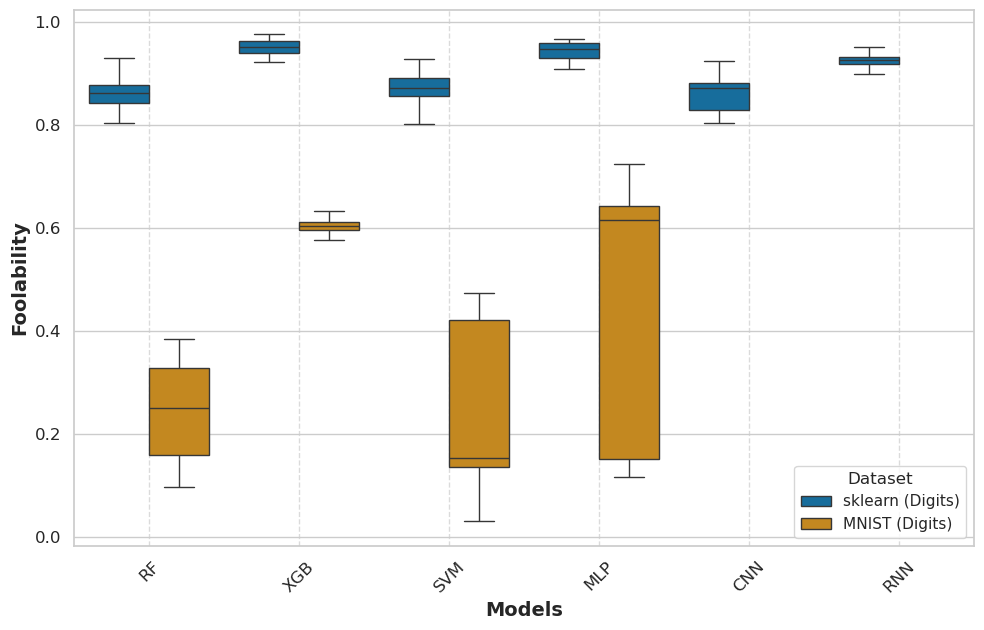

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data1 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_sklearnDigits_aggregated.csv")
data2 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_1b_mnistDigits_aggregated.csv")
# Assign dataset labels
data1["Dataset"] = "sklearn (Digits)"
data2["Dataset"] = "MNIST (Digits)"

# Combine datasets
data = pd.concat([data1, data2])

# Define relevant columns
target_metrics = ["Fitness"]
metric_aliases = {"Fitness": "Foolability"}
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]
dataset_order = ["sklearn (digits)", "MNIST (digits)", "MNIST (fashion)"]

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

### **Comparison Across Datasets with Correct Strip Plot Alignment** ###
plt.figure(figsize=(10, 12))

for i, metric in enumerate(target_metrics, 1):
    plt.subplot(2, 1, i)
    
    # Boxplot with dodge=True for separation
    sns.boxplot(x="Model", y=metric, hue="Dataset", data=data, 
                palette="colorblind", showfliers=False, order=model_order, dodge=True)

    # Add vertical grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.xlabel("Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_aliases[metric], fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    if i == 1:
        plt.legend(title="Dataset")  # Keep dataset legend
    else:
        plt.legend().remove()

plt.tight_layout()
plt.show()


# 3 Datasets

## 1

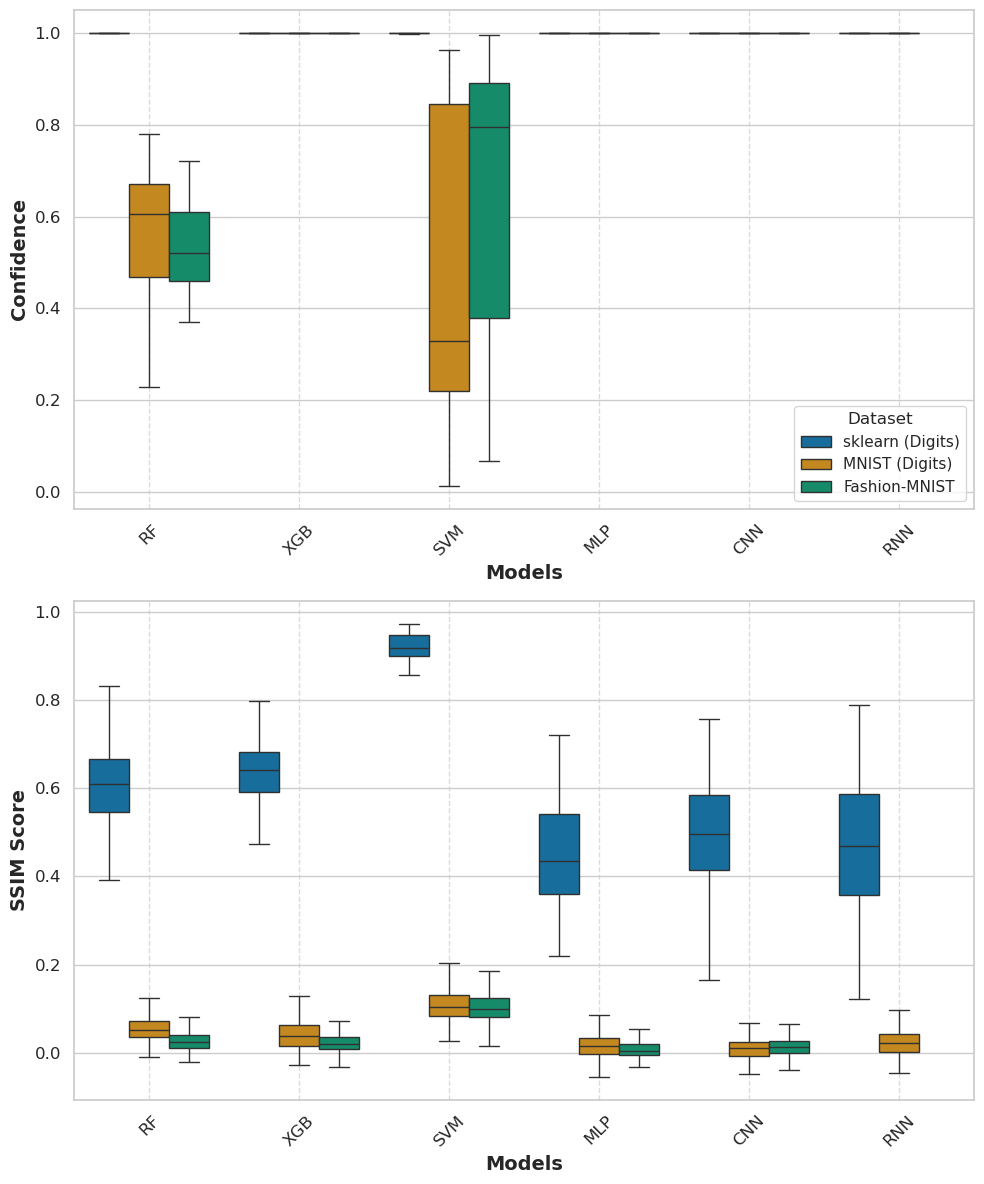

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data1 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_sklearnDigits_aggregated.csv")
data2 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_mnistDigits_aggregated.csv")
data3 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_1_mnistFashion_aggregated.csv")

# Assign dataset labels
data1["Dataset"] = "sklearn (Digits)"
data2["Dataset"] = "MNIST (Digits)"
data3["Dataset"] = "Fashion-MNIST"

# Combine datasets
data = pd.concat([data1, data2, data3])

# Define relevant columns
target_metrics = ["Confidence (Target Class)", "SSIM (Target Class)"]
metric_aliases = {"Confidence (Target Class)": "Confidence", "SSIM (Target Class)": "SSIM Score"}
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]
dataset_order = ["sklearn (digits)", "MNIST (digits)", "MNIST (fashion)"]

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

### **Comparison Across Datasets with Correct Strip Plot Alignment** ###
plt.figure(figsize=(10, 12))

for i, metric in enumerate(target_metrics, 1):
    plt.subplot(2, 1, i)
    
    # Boxplot with dodge=True for separation
    sns.boxplot(x="Model", y=metric, hue="Dataset", data=data, 
                palette="colorblind", showfliers=False, order=model_order, dodge=True)

    # Add vertical grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.xlabel("Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_aliases[metric], fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    if i == 1:
        plt.legend(title="Dataset")  # Keep dataset legend
    else:
        plt.legend().remove()

plt.tight_layout()
plt.show()


## 2

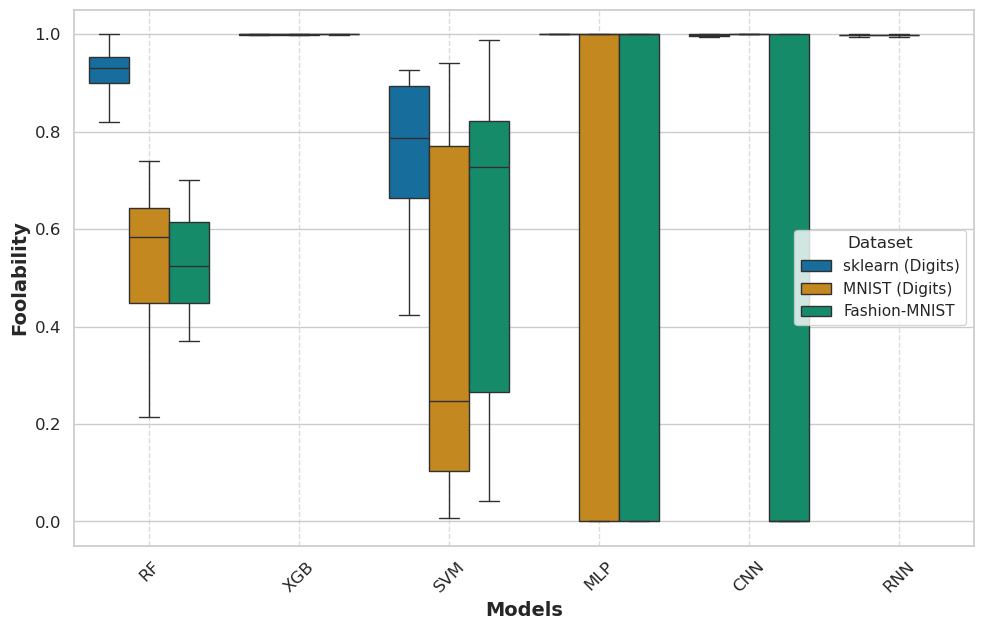

In [130]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
data1 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_sklearnDigits_aggregated.csv")
data2 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_mnistDigits_aggregated.csv")
data3 = pd.read_csv("/media/ankit-gupta/546B-6466/aggregated_data/final_gen_data/Exp_2_2_mnistFashion_aggregated.csv")

# Assign dataset labels
data1["Dataset"] = "sklearn (Digits)"
data2["Dataset"] = "MNIST (Digits)"
data3["Dataset"] = "Fashion-MNIST"

# Combine datasets
data = pd.concat([data1, data2, data3])

# Define relevant columns
target_metrics = ["Fitness"]
metric_aliases = {"Fitness": "Foolability"}
model_order = ["RF", "XGB", "SVM", "MLP", "CNN", "RNN"]
dataset_order = ["sklearn (digits)", "MNIST (digits)", "MNIST (fashion)"]

# Ensure classes are ordered from 0 to 9
data['Class'] = pd.Categorical(data['Class'], categories=[f'class_{i}' for i in range(10)], ordered=True)

### **Comparison Across Datasets with Correct Strip Plot Alignment** ###
plt.figure(figsize=(10, 12))

for i, metric in enumerate(target_metrics, 1):
    plt.subplot(2, 1, i)
    
    # Boxplot with dodge=True for separation
    sns.boxplot(x="Model", y=metric, hue="Dataset", data=data, 
                palette="colorblind", showfliers=False, order=model_order, dodge=True)

    # Add vertical grid lines
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    plt.xlabel("Models", fontsize=14, fontweight='bold')
    plt.ylabel(metric_aliases[metric], fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    
    if i == 1:
        plt.legend(title="Dataset")  # Keep dataset legend
    else:
        plt.legend().remove()

plt.tight_layout()
plt.show()











